# Домашнее задание 3

У вас есть данные о полетах. Для каждого клиента известна краткая информация о самом человеке, о типе билета и о рейсе, а также оценки клиента различным аспектам полета.

Для некоторых клиентов известна их удовлетворенность полетом (satisfied или neutral or dissatisfied). По этим данным необходимо обучить модель, предсказывающую удовлетворенность клиентов полетом. Итоговые предсказания нужно сделать для клиентов, для которых ответ неизвестен.

Компания держит все данные в облаке Яндекса в Postgresql. Данные разбиты на смысловые таблицы. Чтобы получить данные, вам необходимо подключиться к базе данных и добыть оттуда данные.

Продуктивной и интересной вам работы!

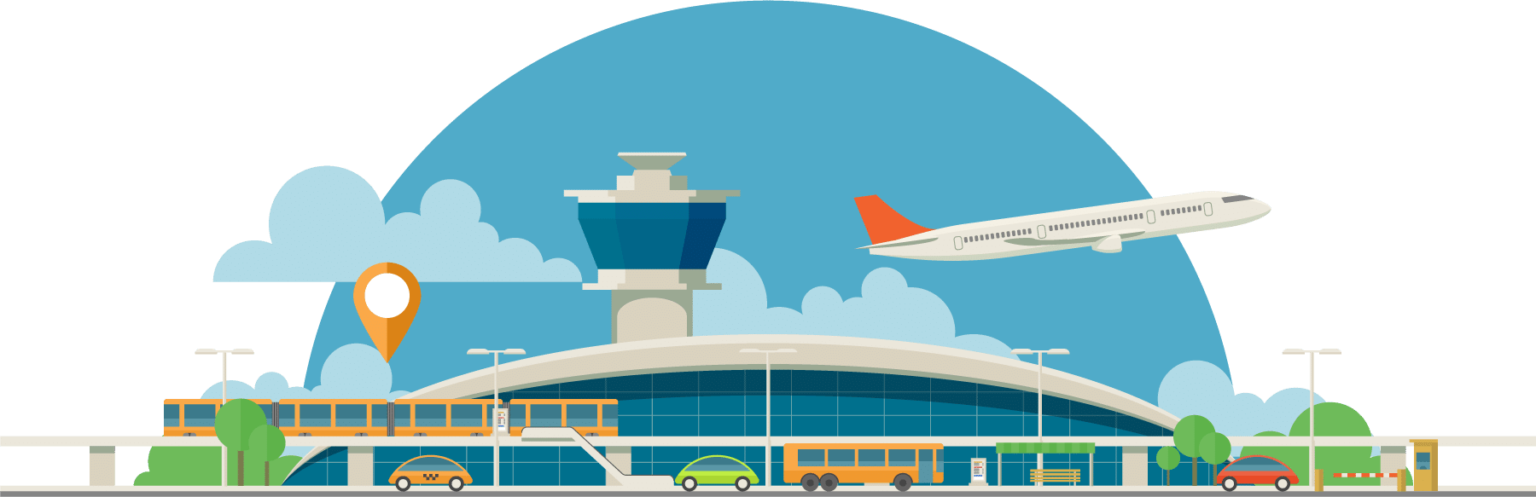

> Задания, <font color='#9933CC'>выделенные фиолетовым</font>, требуют от вас написания кода. <br/> А вопросы, <font color='#FF6600'>выделенные оранжевым</font>, -- текстового ответа.

Оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.

Брать код из открытых источников позволительно. Следование культуре цитирования при этом обязательно

In [1]:
!pip install catboost
!pip install mlxtend --upgrade
!pip install optuna
!pip install lime
!pip install shap
!pip install missingno
!pip install psycopg2-binary
#!pip install xgboost
#!brew install cmake libomp
#!pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 8.2 MB/s eta 0:00:00
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.22.0
    Uninstalling mlxtend-0.22.0:
      Successfully uninstalled mlxtend-0.22.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=02bb23e26857f8d379ea6daa4a663716b5b1d75293c56d30c2e1b365facd2bea
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno

import psycopg2
import psycopg2.extras

from mlxtend.plotting import plot_decision_regions
from mlxtend.evaluate import bias_variance_decomp
from graphviz import Source
from sklearn.tree import export_graphviz
from IPython.display import SVG

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.calibration import CalibrationDisplay
from sklearn.isotonic import IsotonicRegression

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

import shap
import lime
import lime.lime_tabular

import optuna

import pickle

np.random.seed(42)


# Data Prep & EDA (3 балла)

## Загрузка и предобработка данных (1.75 балла)

In [3]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2024-01-20 14:10:28--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3579 (3.5K) [application/x-x509-ca-cert]
Saving to: ‘/root/.postgresql/root.crt’

/root/.postgresql/r 100%[===================>]   3.50K  --.-KB/s    in 0s      

2024-01-20 14:10:28 (1.44 GB/s) - ‘/root/.postgresql/root.crt’ saved [3579/3579]



(0.5 балла) <font color='#9933CC'>Подключитесь к БД при помощи `psycopg2.connect()` и напишите SQL-запрос, объединяющий 3 нужные таблицы в одну</font>.
Список столбцов таблиц добудьте самостоятельно.

<font color='#9933CC'>Результат запроса поместите в `pd.DataFrame`. Индексом получившегося датафрейма сделайте столбец 'id'</font>

> Не забудьте закрыть соединение. Или открывайте соединение, используя менеджер контекста `with as`, который закроет его автоматически

### Параметры соединения
```
host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
port=6432
sslmode=verify-full
dbname=db_flights
user=mlhs_student
password=mlhs_student
target_session_attrs=read-write```
```

### Схема БД

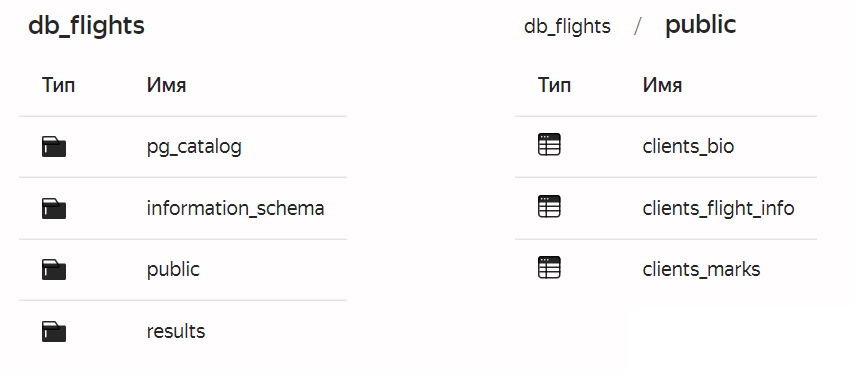

In [168]:
import psycopg2

# Сохраним параметры соединения в переменную
params = {
    "host": "rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net",
    "port": 6432,
    "sslmode": "verify-full",
    "dbname": "db_flights",
    "user": "mlhs_student",
    "password": "mlhs_student",
    "target_session_attrs": "read-write"
}

# Напишем функцию, которая будет выводить названия столбцов в таблицах
def get_table_columns(table_name):
    query = f"""
        SELECT column_name
        FROM information_schema.columns
        WHERE table_schema = 'public' AND table_name = '{table_name}';
    """
    with psycopg2.connect(**params) as conn:
        with conn.cursor() as curs:
            curs.execute(query)
            columns = curs.fetchall()
            return [col[0] for col in columns]

# Выведем столбцы для каждой таблицы, чтобы потом понять как их связать
tables = ["clients_bio", "clients_flight_info", "clients_marks"]
for table in tables:
    columns = get_table_columns(table)
    print(f"Columns in {table}: {columns}")


Columns in clients_bio: ['id', 'gender', 'age']
Columns in clients_flight_info: ['id', 'Customer Type', 'Type of Travel', 'class', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
Columns in clients_marks: ['id', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'cleanliness', 'satisfaction']


In [169]:
# теперь сделаем запрос, выберем нужные столбцы и объединим таблицы. Сохраним все в переменную df
try:
    with psycopg2.connect(**params) as conn:
        query = """
            SELECT
                a.id, a.gender, a.age,
                b."Customer Type", b."Type of Travel", b."class", b."Flight Distance",
                b."Departure Delay in Minutes", b."Arrival Delay in Minutes",
                c."Inflight wifi service", c."Departure/Arrival time convenient",
                c."Ease of Online booking", c."Gate location", c."Food and drink",
                c."Online boarding", c."Seat comfort", c."Inflight entertainment",
                c."On-board service", c."Leg room service", c."Baggage handling",
                c."Checkin service", c."Inflight service", c."cleanliness", c."satisfaction"
            FROM clients_bio a
            INNER JOIN clients_flight_info b ON a.id = b.id
            INNER JOIN clients_marks c ON a.id = c.id;
        """
        df = pd.read_sql_query(query, conn)
        df.set_index('id', inplace=True)

except psycopg2.DatabaseError as e:
    print(f"Database error: {e}")
except Exception as e:
    print(f"Error: {e}")
else:
    print("Query executed successfully. DataFrame is ready.")

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


Query executed successfully. DataFrame is ready.


In [170]:
assert df.shape == (129_549, 23)

(0.25 балла) <font color='#9933CC'>Преобразуйте числовые столбцы в `float`. Проверьте, есть ли в датафрейме пропуски и выбросы (в том числе в категориальных признаках)</font>.

In [171]:
# нужно понять, какие столбцы являются категориальными, а какие числовыми
# выведем все столбцы
df.columns

Index(['gender', 'age', 'Customer Type', 'Type of Travel', 'class',
       'Flight Distance', 'Departure Delay in Minutes',
       'Arrival Delay in Minutes', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'cleanliness', 'satisfaction'],
      dtype='object')

In [172]:
# сделаем функцию для проверки, можно ли преобразовать строку в число
def is_numeric(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

# Примененим функции is_numeric ко всем элементам DataFrame
numeric_mask = df.applymap(is_numeric)

# Выберем столбцы, где все строки можно преобразовать в числа
selected_columns = df.loc[:, numeric_mask.all(axis=0)]

In [173]:
selected_columns.columns

Index(['age', 'Flight Distance', 'Departure Delay in Minutes',
       'Arrival Delay in Minutes', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'cleanliness'],
      dtype='object')

In [174]:
# оставшиеся столбцы будут категориальными
cat_columns = df.drop(columns=selected_columns.columns)
print(cat_columns.columns)

Index(['gender', 'Customer Type', 'Type of Travel', 'class', 'satisfaction'], dtype='object')


In [175]:
# your code below
num_columns = ['age', 'Flight Distance', 'Departure Delay in Minutes',
       'Arrival Delay in Minutes', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'cleanliness']

cat_cols = ['gender', 'Customer Type', 'Type of Travel', 'class', 'satisfaction']

# Приведение числовых столбцов к типу float
df[num_columns] = df[num_columns].apply(pd.to_numeric, errors='coerce')

df.replace('nan', pd.NA, inplace=True)

print(df.isna().sum())

gender                                 0
age                                  315
Customer Type                         77
Type of Travel                       101
class                                116
Flight Distance                       94
Departure Delay in Minutes           107
Arrival Delay in Minutes             507
Inflight wifi service                 44
Departure/Arrival time convenient     49
Ease of Online booking                43
Gate location                         37
Food and drink                        50
Online boarding                       46
Seat comfort                          47
Inflight entertainment                45
On-board service                      44
Leg room service                      46
Baggage handling                      48
Checkin service                       42
Inflight service                      63
cleanliness                           37
satisfaction                           0
dtype: int64


In [176]:
# Проверка на выбросы в числовых столбцах
for col in num_columns:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"Количество выбросов в '{col}': {len(outliers)}")

# Проверка категориальных данных
print("\nПроверка категориальных данных:")
for col in cat_cols:
    print(f"Уникальные значения в '{col}':\n{df[col].value_counts()}")

Количество выбросов в 'age': 448
Количество выбросов в 'Flight Distance': 3074
Количество выбросов в 'Departure Delay in Minutes': 18124
Количество выбросов в 'Arrival Delay in Minutes': 17499
Количество выбросов в 'Inflight wifi service': 24
Количество выбросов в 'Departure/Arrival time convenient': 35
Количество выбросов в 'Ease of Online booking': 29
Количество выбросов в 'Gate location': 39
Количество выбросов в 'Food and drink': 28
Количество выбросов в 'Online boarding': 32
Количество выбросов в 'Seat comfort': 34
Количество выбросов в 'Inflight entertainment': 23
Количество выбросов в 'On-board service': 26
Количество выбросов в 'Leg room service': 39
Количество выбросов в 'Baggage handling': 27
Количество выбросов в 'Checkin service': 16103
Количество выбросов в 'Inflight service': 39
Количество выбросов в 'cleanliness': 25

Проверка категориальных данных:
Уникальные значения в 'gender':
Female    65726
Male      63823
Name: gender, dtype: int64
Уникальные значения в 'Customer 

(0.5 балла) <font color='#9933CC'>Воспользуйтесь модулем `missingno` для визуализации пропусков в датафрейме</font>

Нас интересует `matrix` пропущенных значений и столбцатая диаграмма в логарифмированной шкале (*пропусков немного => по обычной не будет видно, в каких столбцах их больше*)

<Axes: >

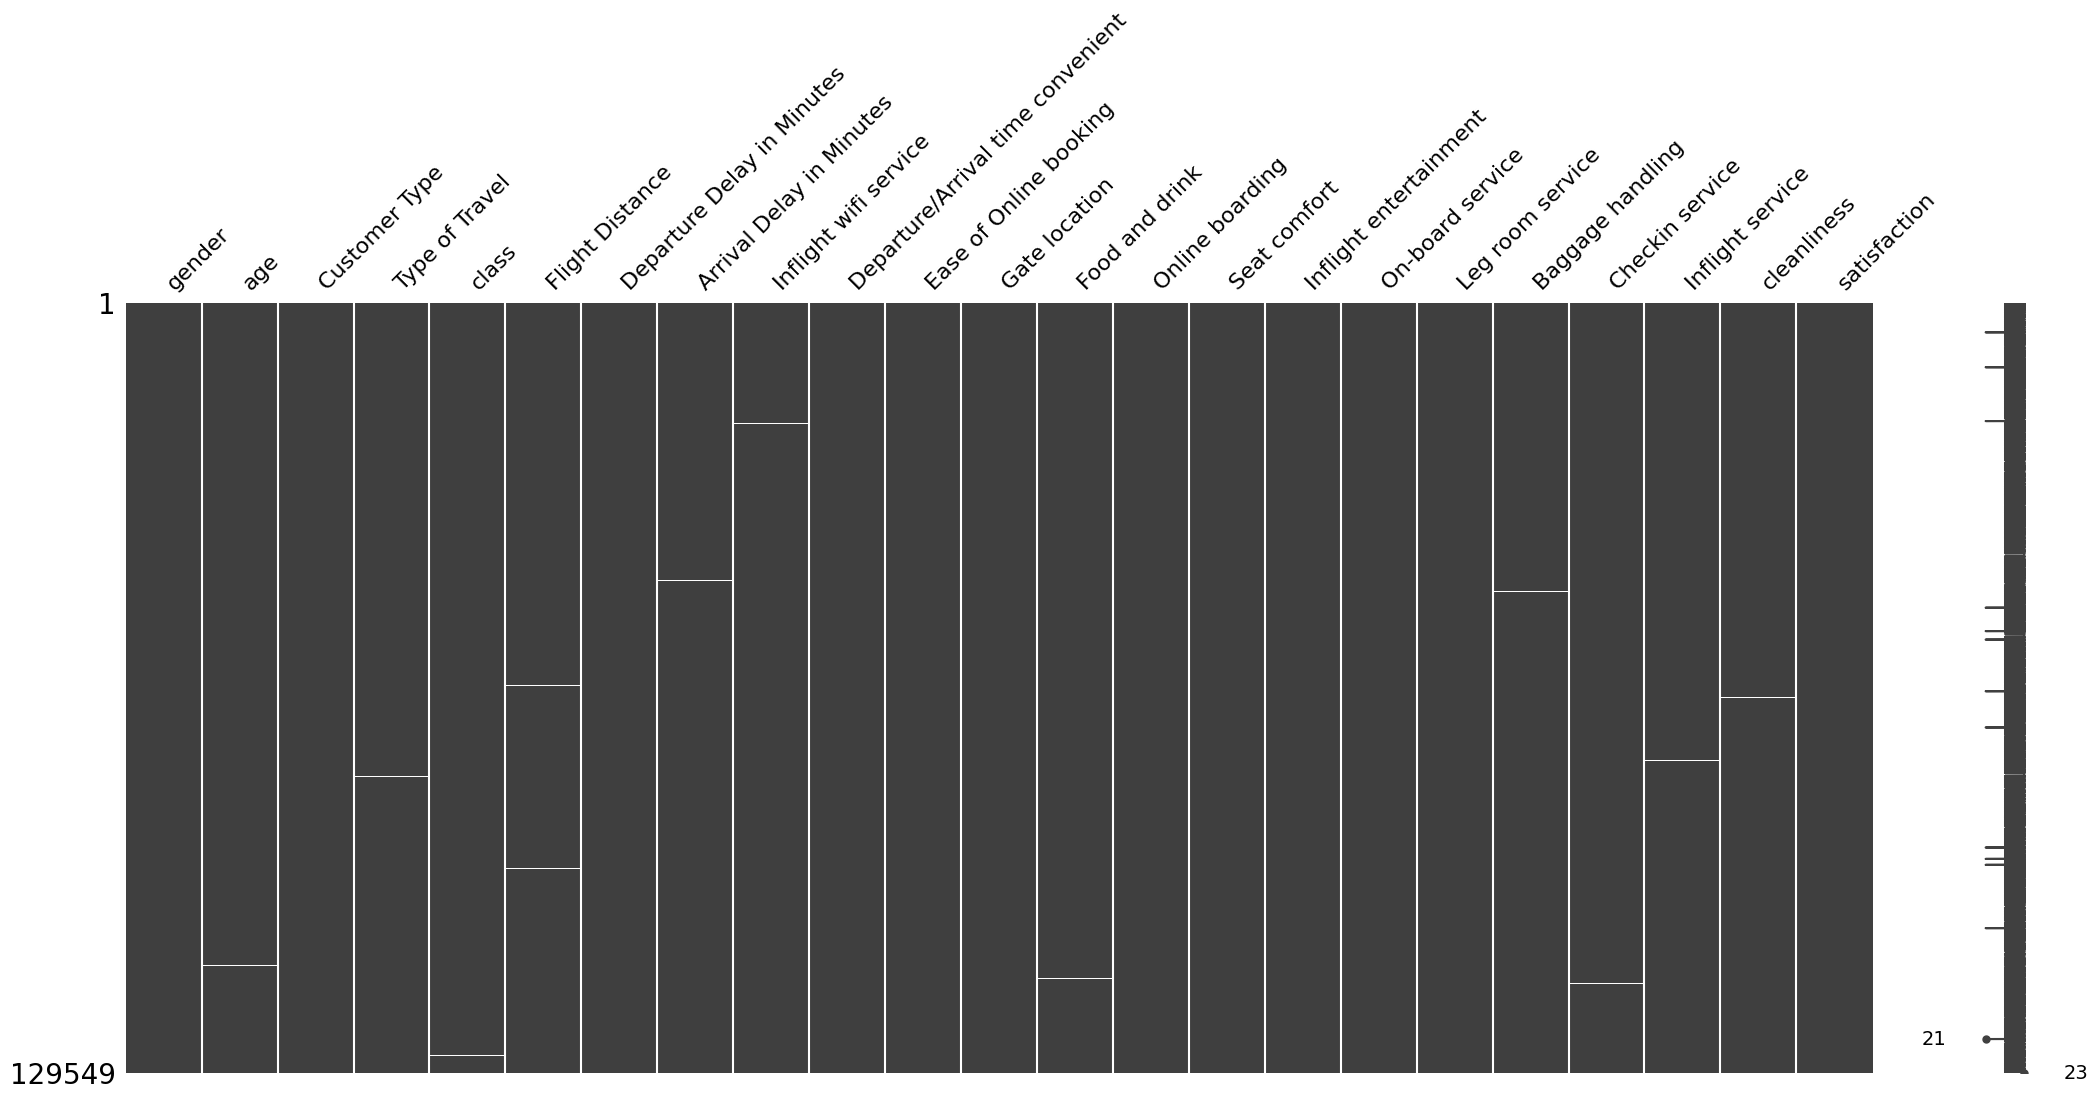

In [151]:
# your code below
missingno.matrix(df)

FixedFormatter should only be used together with FixedLocator


<Axes: >

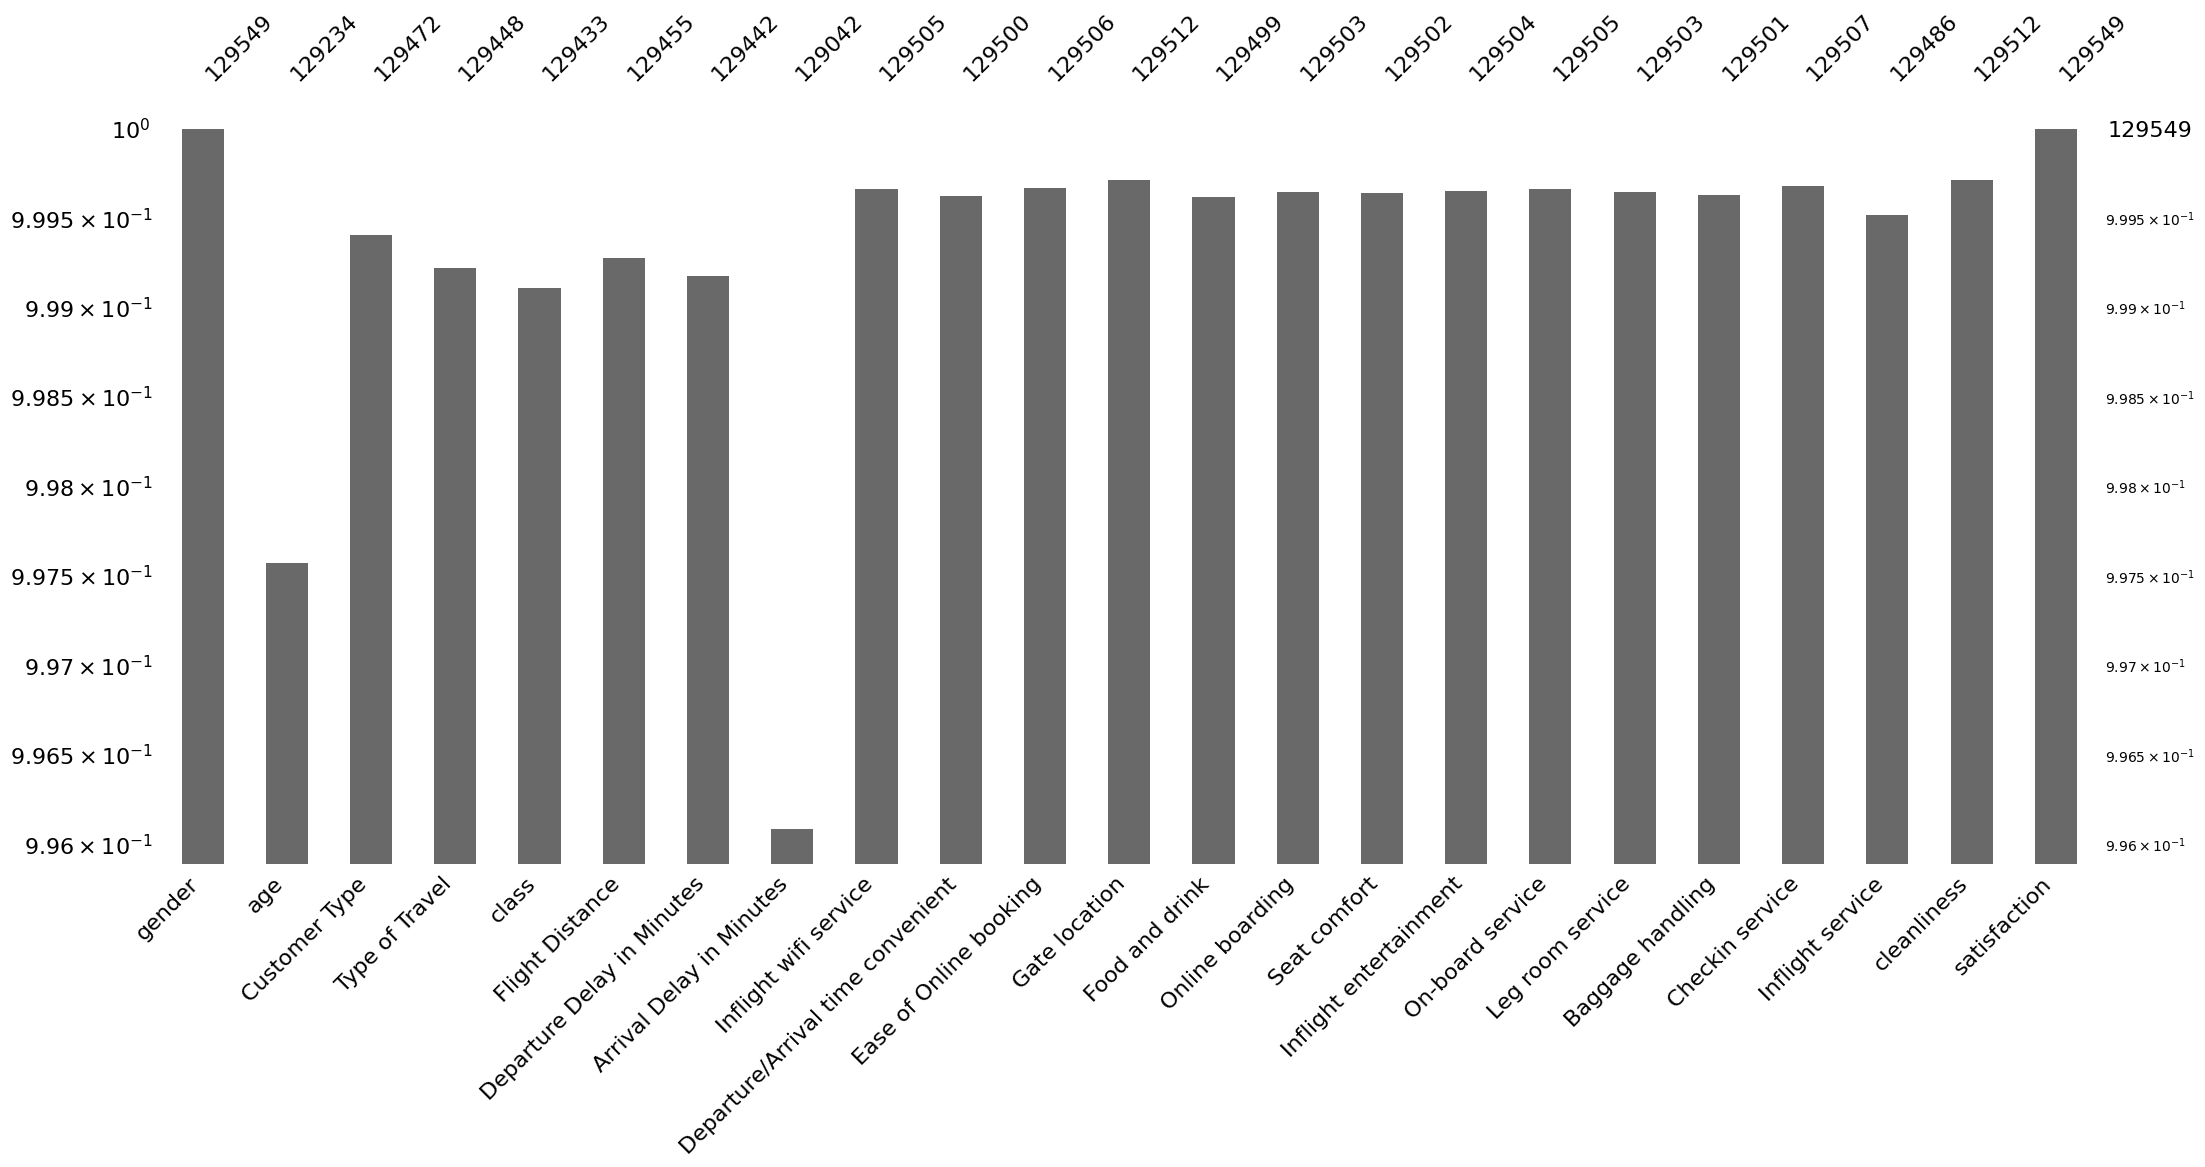

In [95]:
# your code below
missingno.bar(df, log = True)

Разобьем датасет на тренировочную и тестовую части. Тестовую часть отложим надолго -- до самого конца этого ноутбука

In [177]:
df_train = df[df.satisfaction != '-']
df_train

gender   age      Customer Type   Type of Travel     class  \
id                                                                   
7         Male  43.0     Loyal Customer  Business travel  Business   
13        Male  24.0  disloyal Customer  Business travel       Eco   
18      Female  61.0     Loyal Customer  Personal Travel       Eco   
31        Male  35.0  disloyal Customer  Business travel  Business   
39      Female  46.0     Loyal Customer  Business travel  Business   
...        ...   ...                ...              ...       ...   
129831  Female  28.0     Loyal Customer  Personal Travel       Eco   
129837    Male  66.0     Loyal Customer  Personal Travel       Eco   
129838  Female  59.0     Loyal Customer  Personal Travel       Eco   
129839    Male  61.0     Loyal Customer  Personal Travel       Eco   
129846    Male  44.0     Loyal Customer  Personal Travel       Eco   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
id                                                                              
7                1963.0                         0.0                       0.0   
13                453.0                        16.0                      30.0   
18                821.0                         0.0                       0.0   
31                212.0                         0.0                       0.0   
39                 67.0                         0.0                       0.0   
...                 ...                         ...                       ...   
129831            447.0                        23.0                      16.0   
129837            337.0                       199.0                     213.0   
129838            308.0                        32.0                      24.0   
129839            337.0                         0.0                       0.0   
129846            447.0                         0.0                       0.0   

        Inflight wifi service  Departure/Arrival time convenient  ...  \
id                                                                ...   
7                         3.0                                3.0  ...   
13                        2.0                                2.0  ...   
18                        2.0                                5.0  ...   
31                        2.0                                2.0  ...   
39                        3.0                                3.0  ...   
...                       ...                                ...  ...   
129831                    1.0                                3.0  ...   
129837                    2.0                                4.0  ...   
129838                    3.0                                5.0  ...   
129839                    2.0                                4.0  ...   
129846                    2.0                                5.0  ...   

        Online boarding  Seat comfort  Inflight entertainment  \
id                                                              
7                   4.0           5.0                     5.0   
13                  2.0           5.0                     5.0   
18                  1.0           5.0                     5.0   
31                  2.0           2.0                     2.0   
39                  5.0           4.0                     4.0   
...                 ...           ...                     ...   
129831              1.0           3.0                     3.0   
129837              5.0           5.0                     5.0   
129838              5.0           5.0                     3.0   
129839              2.0           3.0                     3.0   
129846              2.0           5.0                     5.0   

        On-board service  Leg room service  Baggage handling  Checkin service  \
id                                                                              
7                    5.0               5.0               5.0              4.0   
13  

In [97]:
assert df_train.shape == (103_644, 23)

In [178]:
df_test = df[df.satisfaction == '-'].drop('satisfaction', axis=1)
df_test

gender   age   Customer Type   Type of Travel     class  \
id                                                                
55        Male  36.0  Loyal Customer  Business travel  Business   
79      Female  70.0  Loyal Customer  Personal Travel       Eco   
126       Male  66.0  Loyal Customer  Personal Travel       Eco   
199     Female  60.0  Loyal Customer  Business travel  Business   
263       Male  43.0  Loyal Customer  Personal Travel  Business   
...        ...   ...             ...              ...       ...   
129750    Male  38.0  Loyal Customer  Business travel       Eco   
129771    Male  16.0  Loyal Customer  Personal Travel       Eco   
129798  Female  43.0  Loyal Customer  Personal Travel       Eco   
129868    Male  47.0  Loyal Customer  Business travel  Eco Plus   
129876    Male  28.0  Loyal Customer  Personal Travel  Eco Plus   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
id                                                                              
55               3655.0                        40.0                      71.0   
79                108.0                        50.0                      41.0   
126               562.0                        88.0                      84.0   
199              3756.0                        36.0                      24.0   
263               802.0                         0.0                       0.0   
...                 ...                         ...                       ...   
129750            337.0                        92.0                      82.0   
129771            308.0                         2.0                       0.0   
129798            308.0                         0.0                       0.0   
129868            447.0                         0.0                       0.0   
129876            447.0                         2.0                       3.0   

        Inflight wifi service  Departure/Arrival time convenient  ...  \
id                                                                ...   
55                        1.0                                1.0  ...   
79                        5.0                                4.0  ...   
126                       2.0                                5.0  ...   
199                       4.0                                4.0  ...   
263                       1.0                                2.0  ...   
...                       ...                                ...  ...   
129750                    4.0                                3.0  ...   
129771                    3.0                                4.0  ...   
129798                    2.0                                4.0  ...   
129868                    3.0                                4.0  ...   
129876                    4.0                                4.0  ...   

        Food and drink  Online boarding  Seat comfort  Inflight entertainment  \
id                                                                              
55                 1.0              3.0           3.0                     3.0   
79                 4.0              4.0           4.0                     3.0   
126                5.0              2.0           5.0                     5.0   
199                2.0              4.0           5.0                     4.0   
263                2.0              3.0           3.0                     2.0   
...                ...              ...           ...                     ...   
129750             4.0              5.0           4.0                     4.0   
129771             1.0              3.0           5.0                     1.0   
129798             3.0              5.0           5.0                     4.0   
129868             4.0              3.0           4.0                     4.0   
129876             4.0              4.0           1.0                     4.0   

        On-board service  Leg room service  Baggage handling  Checkin service 

In [99]:
assert df_test.shape == (25_905, 22)

Разбиваем данные на трейн и валидацию. Не меняйте сид

In [180]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('satisfaction', axis=1), df_train.satisfaction, test_size=0.3, random_state=42)

In [181]:
assert X_train.shape == (72_550, 22)
assert X_val.shape == (31_094, 22)

(0.25 балла) <font color='#9933CC'>Заполните пропуски в данных наиболее часто встречающимся значением</font>.
Обратите внимание, что правильная стратегия заполнения пропусков выглядит так:

* посчитать моды для `X_train`
* ими заполнить пропуски в `X_train`, `X_val` и `df_test`

Было бы неплохо воспользоваться другой стратегией: восстановать пропуски `KNNImputer`'ом или `IterativeImputer`'ом. Но для признаков в нашей задаче они в чистом виде бы, увы, скорее, не подошли. Импьютеры возвращали бы вещественные значения, а в нашей задаче все признаки целые.

В общем, для изящного и удобного для применения в пайплайне заполнения пропусков, пришлось бы кодить самописные классы. Этим можете заняться в бонусной части.

In [182]:
# your code below
modas = X_train.mode().iloc[0]

# Использую моды для заполнения пропусков в X_train, X_val и df_test
X_train = X_train.fillna(modas)
X_val = X_val.fillna(modas)
df_test = df_test.fillna(modas)

In [183]:
# сразу сделал заготовку для блока с деревьями, так как следующим шагом мы будем преобразовывать наш тренировочный набор
X_train_tree = X_train
X_val_tree = X_val
df_test_tree = df_test

<font color='#9933CC'>Выведите основные статистики по числовым и категориальным столбцам таблицы `X_train`</font>

In [103]:
# the place for you to code
X_train.describe()

age  Flight Distance  Departure Delay in Minutes  \
count  72550.000000     72550.000000                72550.000000   
mean      40.098856      1329.018332                   15.859366   
std       20.658196      4764.369357                   70.861937   
min        0.000000         0.000000                    0.000000   
25%       27.000000       413.000000                    0.000000   
50%       40.000000       844.000000                    0.000000   
75%       51.000000      1744.000000                   12.000000   
max      544.000000    379620.000000                 9282.000000   

       Arrival Delay in Minutes  Inflight wifi service  \
count              72550.000000           72550.000000   
mean                  16.645968               2.733687   
std                   97.990293               1.362172   
min                    0.000000               0.000000   
25%                    0.000000               2.000000   
50%                    0.000000               3.000000   
75%                   13.000000               4.000000   
max                11760.000000              45.000000   

       Departure/Arrival time convenient  Ease of Online booking  \
count                       72550.000000            72550.000000   
mean                            3.065017                2.761006   
std                             1.552254                1.414843   
min                             0.000000                0.000000   
25%                             2.000000                2.000000   
50%                             3.000000                3.000000   
75%                             4.000000                4.000000   
max                            45.000000               28.000000   

       Gate location  Food and drink  Online boarding  Seat comfort  \
count   72550.000000    72550.000000     72550.000000  72550.000000   
mean        2.982688        3.209318         3.256513      3.445665   
std         1.316648        1.349963         1.372739      1.346077   
min         0.000000        0.000000         0.000000      0.000000   
25%         2.000000        2.000000         2.000000      2.000000   
50%         3.000000        3.000000         3.000000      4.000000   
75%         4.000000        4.000000         4.000000      5.000000   
max        36.000000       36.000000        32.000000     45.000000   

       Inflight entertainment  On-board service  Leg room service  \
count            72550.000000      72550.000000      72550.000000   
mean                 3.362150          3.383101          3.352364   
std                  1.360862          1.333758          1.360180   
min                  0.000000          0.000000          0.000000   
25%                  2.000000          2.000000          2.000000   
50%                  4.000000          4.000000          4.000000   
75%                  4.000000          4.000000          4.000000   
max                 40.000000         45.000000         36.000000   

       Baggage handling  Checkin service  Inflight service   cleanliness  
count      72550.000000     72550.000000      72550.000000  72550.000000  
mean           3.630255         3.309056          3.640234      3.291178  
std            1.227853         1.293114          1.215114      1.343302  
min            0.000000         0.000000          0.000000      0.000000  
25%            3.000000         3.000000          3.000000      2.000000  
50%            4.000000         3.000000          4.000000      3.000000  
75%            5.000000         4.000000          5.000000      4.000000  
max           40.000000        45.000000         36.000000     45.000000

<font color='#FF6600'>Что вы можете сказать про распределение значений признаков?</font>

  ### Разброс возраста (age).
  
  Средний возраст около 40 лет со стандартным отклонением около 20 лет. Максимальный возраст 544 года явно является выбросом, так как  это невозможно.

 ### Дистанция полета (Flight Distance)

  Существенный разброс значений с максимальным значением в 379620, это может быть ошибка меры или просто ошибка, так как нереалистичное значение.

 ### Задержки (Departure Delay in Minutes, Arrival Delay in Minutes)

  Оба признака имеют высокие максимальные значения (9282 и 11760 минут соответственно), что также указывает на выбросы или ошибки в данных. Средние значения и стандартные отклонения также довольно высоки, что может свидетельствовать о широком распределении задержек.


 ### Оценки услуг (Inflight wifi service до cleanliness)

  Это рейтинговые данные. Максимальные значения в этих столбцах (например, 45) выходят за пределы обычных рейтинговых шкал (например, 1-5), что указывает на возможные ошибки или выбросы.

Для большинства признаков медиана не сильно отличается от среднего значения, что может указывать на относительную симметричность распределения данных.

В целом, данные требуют дополнительной очистки, особенно для исправления или удаления выбросов.

(0.25 балла) <font color='#9933CC'>Удалите строки c выбросами в числовых столбцах</font> (для трейна и валидации; тест оставьте без изменений). Выбросами считайте значения признака, строго превышающие 0.996-квантиль


---
<br/>

*Откуда взялся именно 0.996-квантиль?*

*В рамках анализа данных на выборсы вы вполне могли заметить, какие значения признаков встречаются редко. В среднем для всех признаков эти значения начинаются ~в этом квантиле*

In [165]:
# place for you to code
# Рассчитываем 0.996-квантиль для X_train
quantile = X_train.quantile(0.996, numeric_only=True)
X_train = X_train[~(X_train[quantile.index].gt(quantile.values, axis='columns').any(axis=1))]
y_train_new = y_train.loc[X_train.index]
X_val = X_val[~(X_val[quantile.index].gt(quantile.values, axis='columns').any(axis=1))]
y_val_new = y_val.loc[X_val.index]

In [159]:
X_train.shape

(71395, 22)

In [164]:
assert X_train.shape == (71_369, 22)
assert X_val.shape == (30_609, 22)
assert df_test.shape == (25_905, 22)

AssertionError: 

## EDA (1.25 балла)

Создадим переменные с перечислениями столбцов разного типа

In [166]:
continuous_cols = ['age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
ordinal_cols = list(set(df.select_dtypes(include='number').columns) - set(continuous_cols))
categorical_cols = list(df.select_dtypes(include='object').columns)[:-1]

In [167]:
assert len(continuous_cols + ordinal_cols + categorical_cols) == 22

(0.5 балла) <font color='#9933CC'>Напишите процедуры для отрисовки графиков</font>

* Для признаков, которые мы выделили как порядковые, отображайте только `countplot`
* Для тех, что считаем континуальными, -- гистограмму распределения признака и ящик с усами (inline)
* Для категориальных -- только `countplot`

Обязательно выделяйте таргет разными цветами. Мы же хотим в конечном итоге понять, чем удовлетворенные клиенты отличаются от недовольных.

> Все графики и их оси обязательно должны быть подписаны, легенда на графике также необходима

In [109]:
def plot_ordinal(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    for col in cols:
        plt.figure(figsize=(6, 4))
        sns.countplot(data=df, x=col, hue=y)
        plt.title(f'Countplot of {col} grouped by target')
        plt.show()

In [115]:
def plot_continuous(cols, df, y):
    """Draws kdeplots and boxplots in one row
    for all columns in 'cols' with informative title
    """
    for col in cols:
      plt.figure(figsize=(12,6))
      plt.subplot(1, 2, 1)
      plt.title(f'{col} distribution')
      sns.kdeplot(df, x=col, hue=y)
      plt.subplot(1, 2, 2)
      plt.title(f'{col} boxplot by target')
      sns.boxplot(df, x=col, y=y)
      plt.show()

In [111]:
def plot_categorical(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    for col in cols:
        plt.figure(figsize=(6, 4))
        sns.countplot(data=df, x=col, hue=y)
        plt.title(f'Countplot of {col} grouped by target')
        plt.show()

<font color='#9933CC'>Вызовите все 3 написанные процедуры для соответствующих колонок `X_train`. Отдельно визуализируйте распределение таргета в трейне</font>

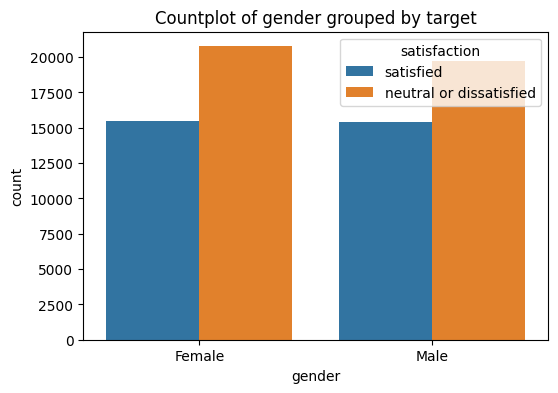

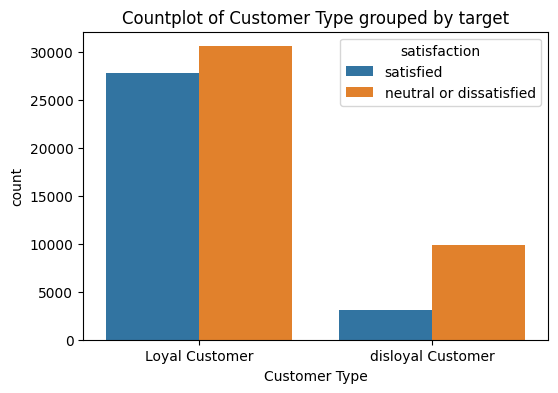

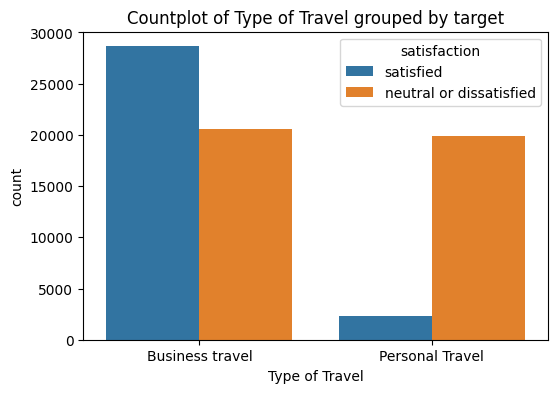

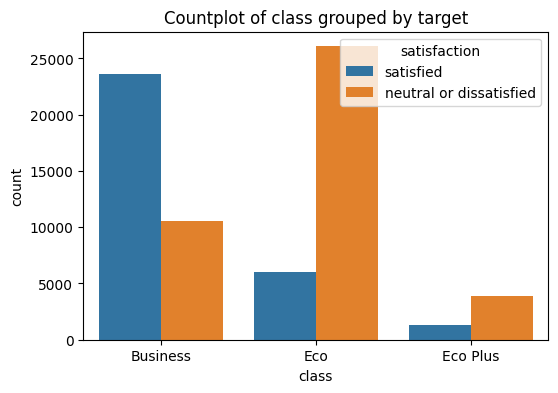

In [112]:
plot_categorical(categorical_cols, X_train, y_train)

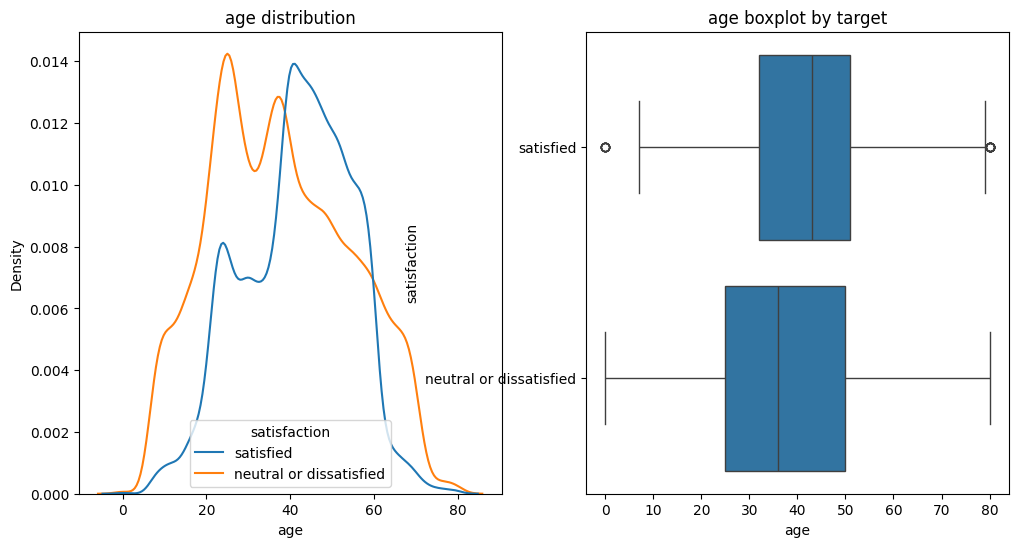

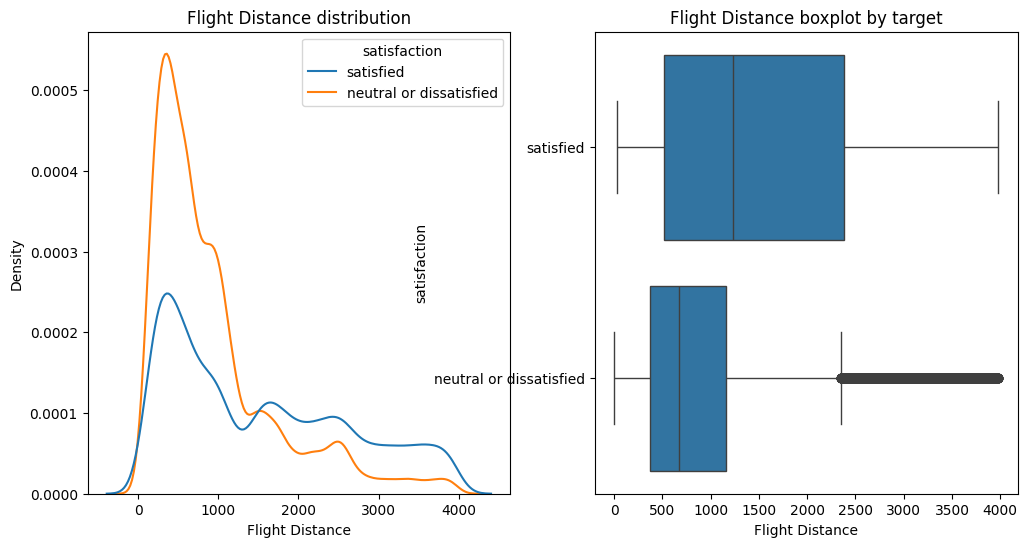

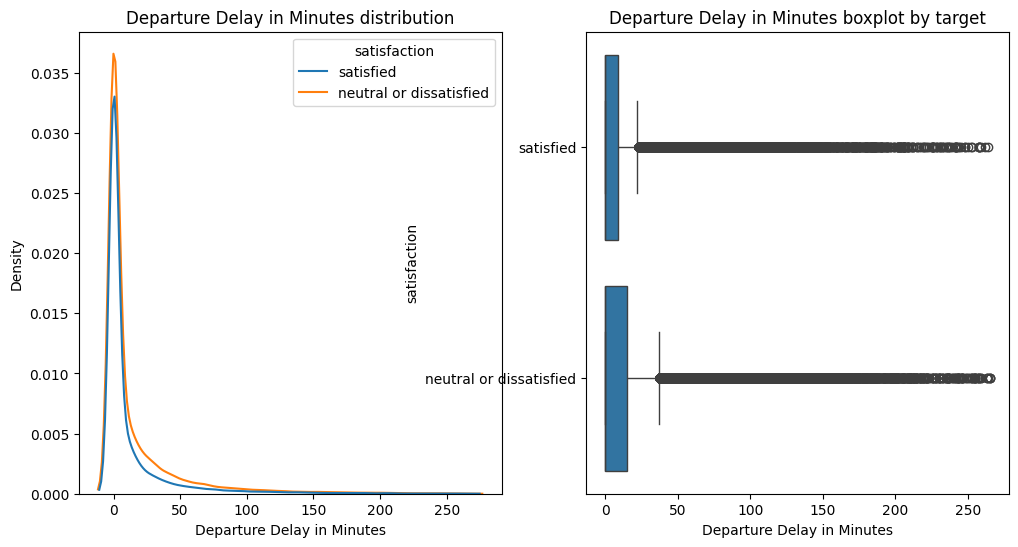

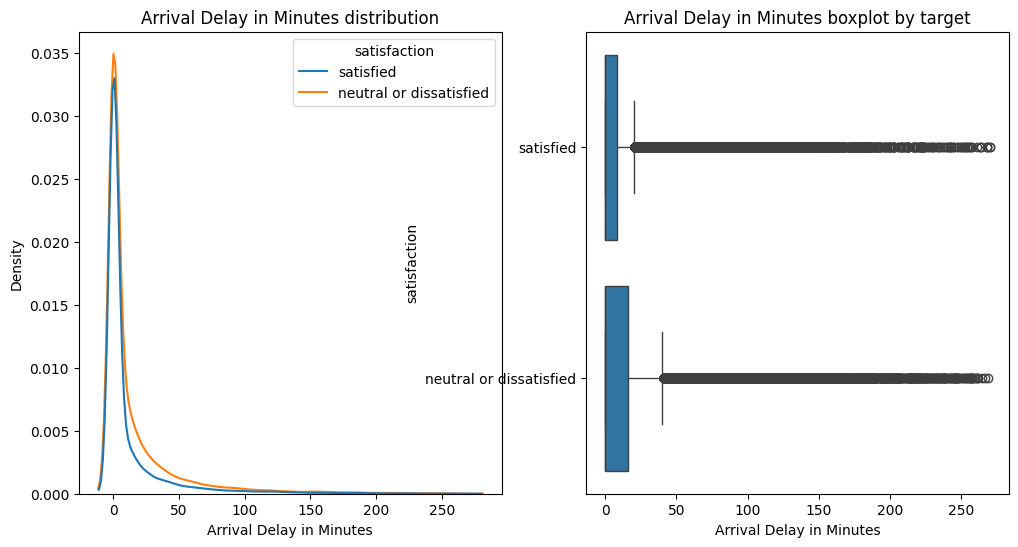

In [116]:
plot_continuous(continuous_cols, X_train, y_train)

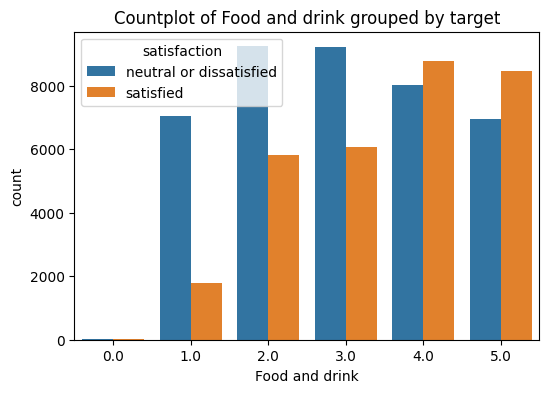

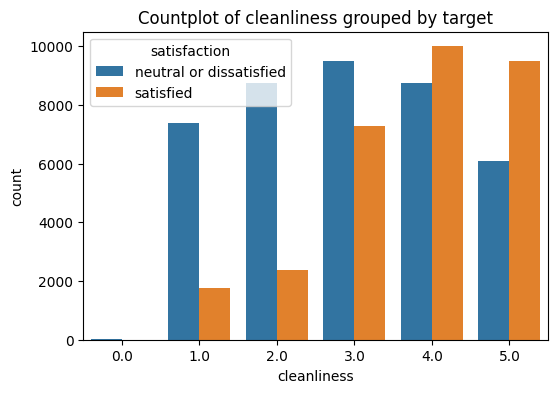

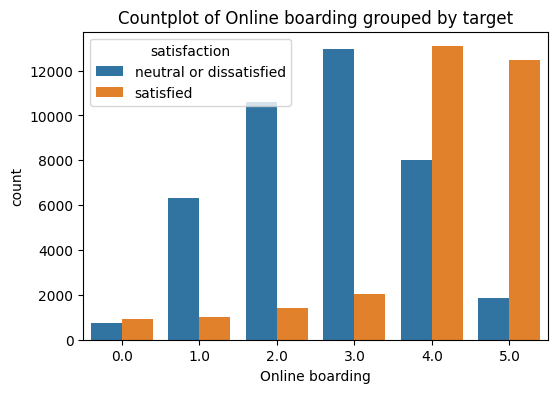

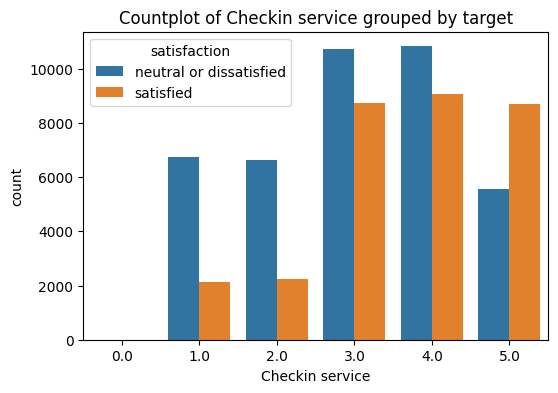

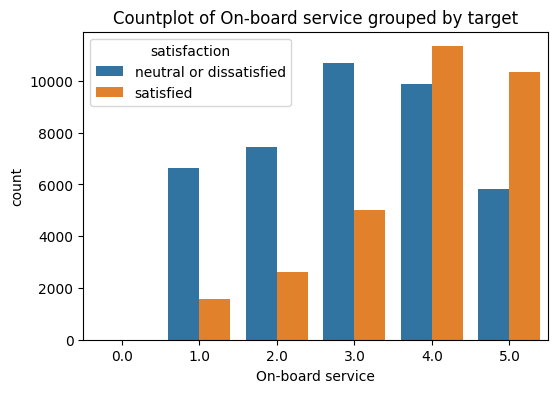

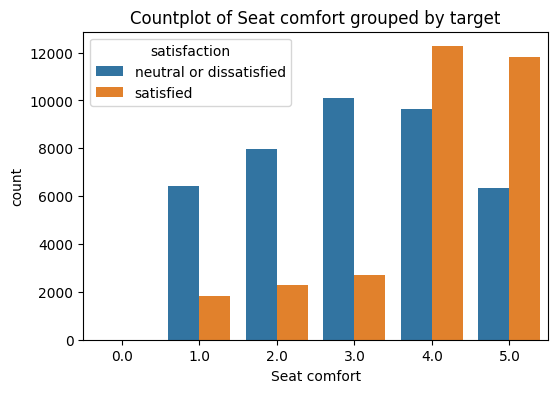

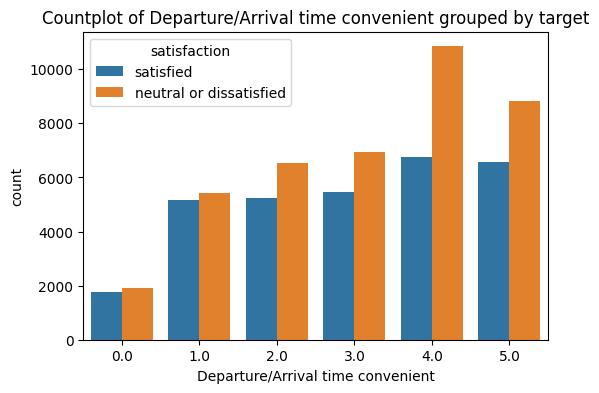

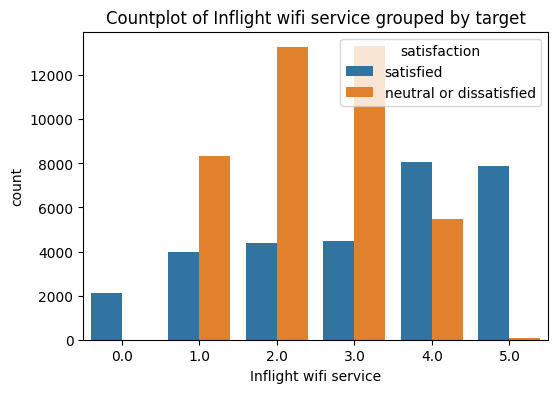

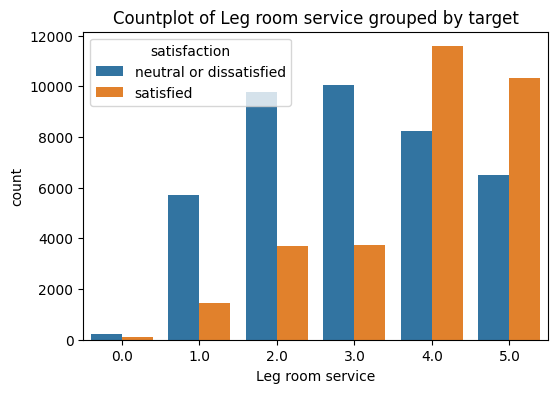

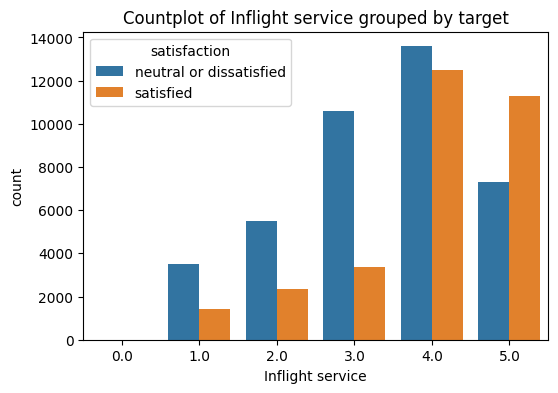

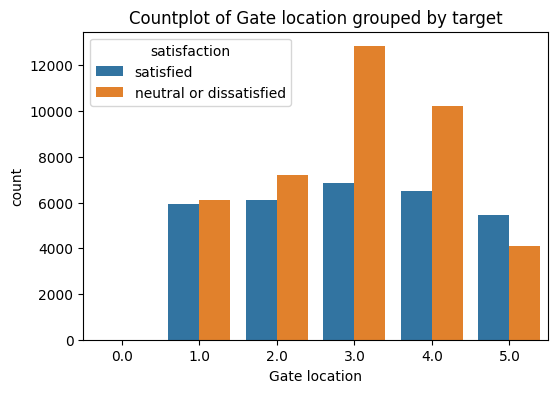

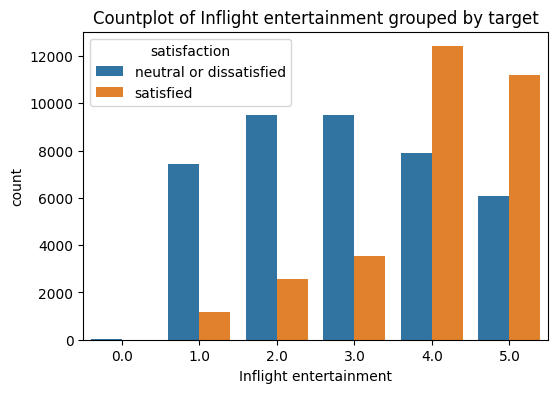

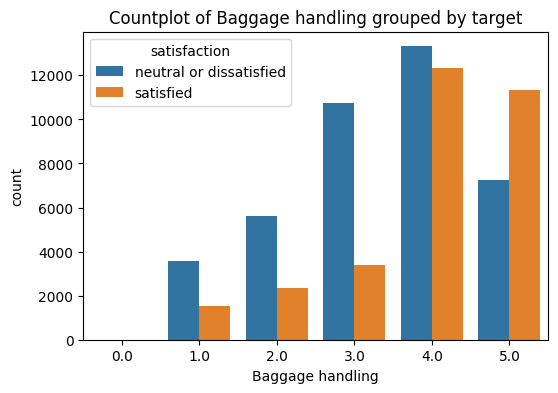

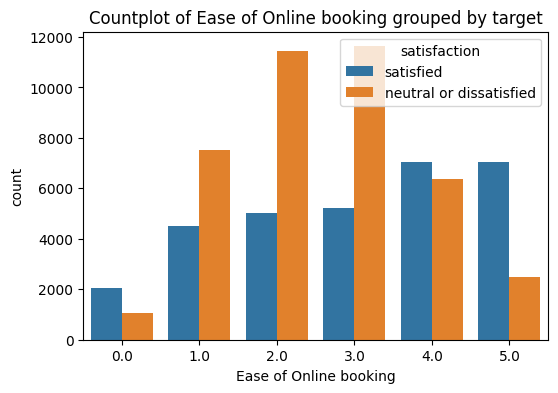

In [114]:
plot_ordinal(ordinal_cols, X_train, y_train)

<Axes: title={'center': ' The distribution of satisfaction'}, xlabel='satisfaction', ylabel='count'>

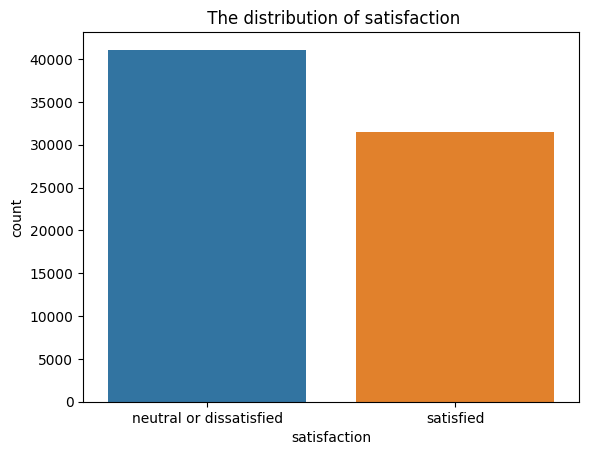

In [122]:
# visualize y_train
plt.title(' The distribution of satisfaction')
sns.countplot(data=X_train, x=y_train, hue=y_train)

<font color='#FF6600'>Сделайте выводы по построенным графикам</font>. Полезно было бы упомянуть:
* какие признаки распределены неравномерно
* сбалансированы ли классы
* какие распределения имеют континуальные признаки

In [ ]:
# your answer her
# feel free to change this cell from code to markdown

###Неравномерное распределение признаков

#Например, Customer Type преобладает значение Loyal Customer, что указывает на неравномерное распределение. Аналогично, в Type of Travel преобладает Business travel.
#Такие неравномерные распределения могут влиять на модель машинного обучения, предвзято отдавая предпочтение более частым категориям.

###Сбалансированность классов
#классы выглядят сбалансированными. Это хороший знак для обучения модели, так как дисбаланс классов может привести к смещению в пользу более частого класса

### Распределения континуальных признаков:
# age - cредний возраст составляет около 39 лет со стандартным отклонением 15 лет, максимальный возраст - 80 лет, что указывает на разнообразие возрастных групп.
# Flight Distance: В среднем 1180 км с большим стандартным отклонением (987 км), что указывает на широкий диапазон значений.
# Departure Delay in Minutes и Arrival Delay in Minutes - имеют среднее значение около 13-14 минут, но с большим стандартным отклонением, что может указывать на некоторые значительные задержки.


(Бонус: 0.25 балла) <font color='#9933CC'>По графикам (каким, решите сами) оцените, похожи ли оказались распределения признаков при разбиении на трейн, валидацию и тест </font>

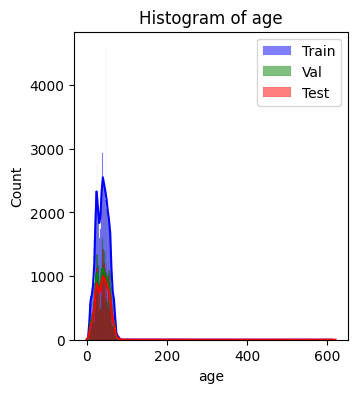

In [129]:
# your code below
#  для подобного сравнения лучше всего подходит гистограмма
def compare_distributions(feature):
    plt.figure(figsize=(12, 4))

    # Гистограммы
    plt.subplot(1, 3, 1)
    sns.histplot(df_train[feature], kde=True, color='blue', label='Train')
    sns.histplot(X_val[feature], kde=True, color='green', label='Val')
    sns.histplot(df_test[feature], kde=True, color='red', label='Test')
    plt.title(f'Histogram of {feature}')
    plt.legend()

# здесь пример вызова функции для числового признака 'age', но можно вставить вместо возраста другие признаки
compare_distributions('age')

 # распределения похожи чаще всего

(0.25 балла) Давайте <font color='#9933CC'>заменим признаки "Departure Delay in Minutes" и "Arrival Delay in Minutes" на их логарифмы.</font>

In [130]:
# your code
# Заменяем признаки их логарифмами
X_train['Departure Delay in Minutes'] = np.log1p(X_train['Departure Delay in Minutes'])
X_train['Arrival Delay in Minutes'] = np.log1p(X_train['Arrival Delay in Minutes'])
X_val['Departure Delay in Minutes'] = np.log1p(X_val['Departure Delay in Minutes'])
X_val['Arrival Delay in Minutes'] = np.log1p(X_val['Arrival Delay in Minutes'])
df_test['Departure Delay in Minutes'] = np.log1p(df_test['Departure Delay in Minutes'])
df_test['Arrival Delay in Minutes'] = np.log1p(df_test['Arrival Delay in Minutes'])

Теперь заново <font color='#9933CC'>постройте графики континуальных признаков</font>

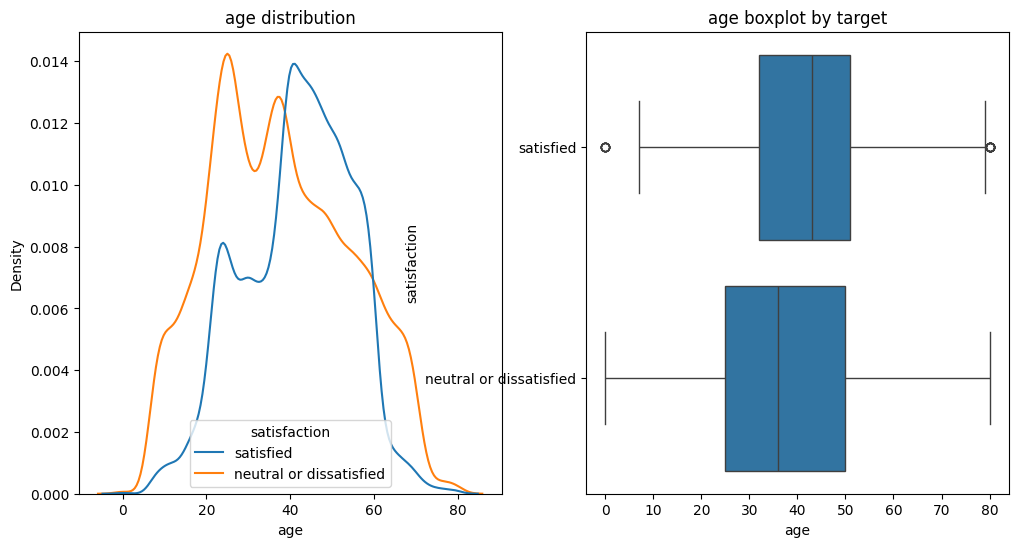

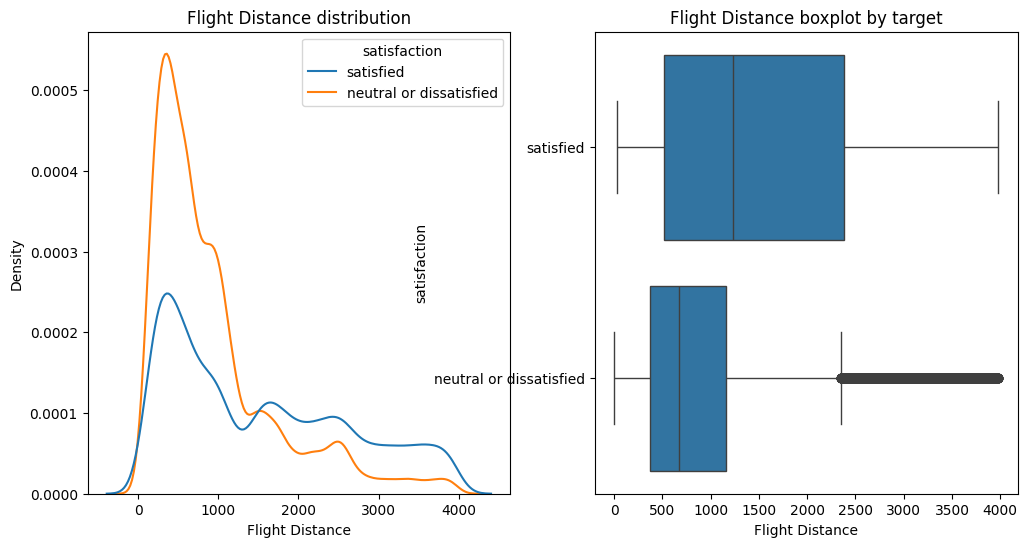

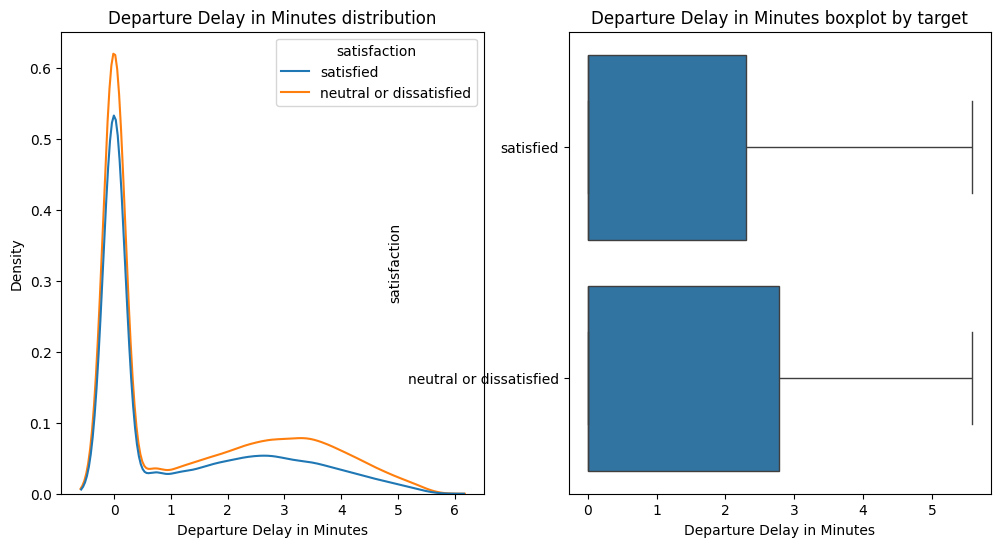

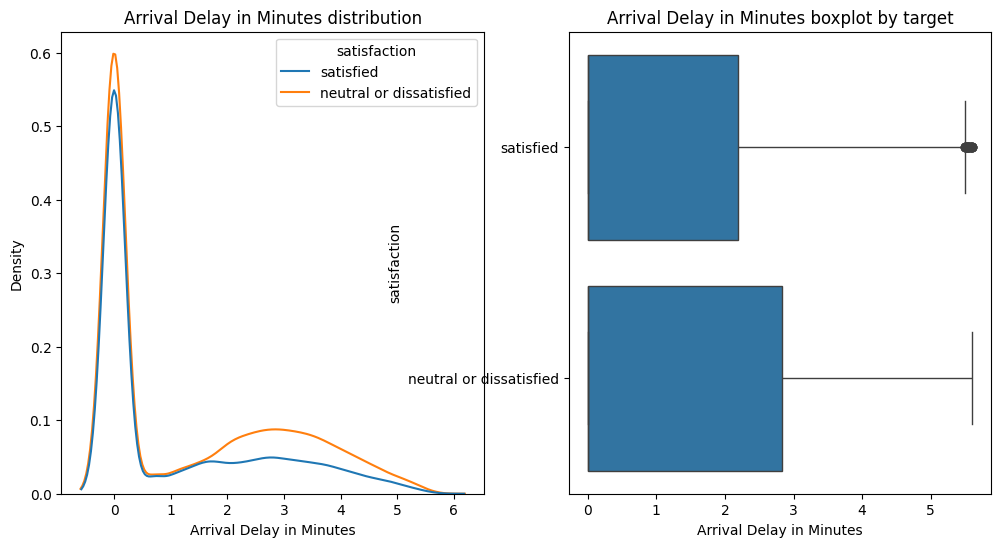

In [131]:
plot_continuous(continuous_cols, X_train, y_train)

<font color='#9933CC'>Закодируйте таргет таким образом, чтоб 'satisfied' перешел в 1, а остальные значения в 0</font>

In [132]:
# your code
y_train = (y_train == 'satisfied').astype(int)
y_val = (y_val == 'satisfied').astype(int)

In [140]:
y_train.shape

(72550,)

In [142]:
X_train.shape

(71395, 22)

(0.25 балла) <font color='#9933CC'>Отобразите попарное распределение континуальных (по договоренности) признаков. Покрасьте точки на pairplot'е в соответствии с их классом</font>. Наблюдений много, так что отрисовка графика вполне может занять несколько минут

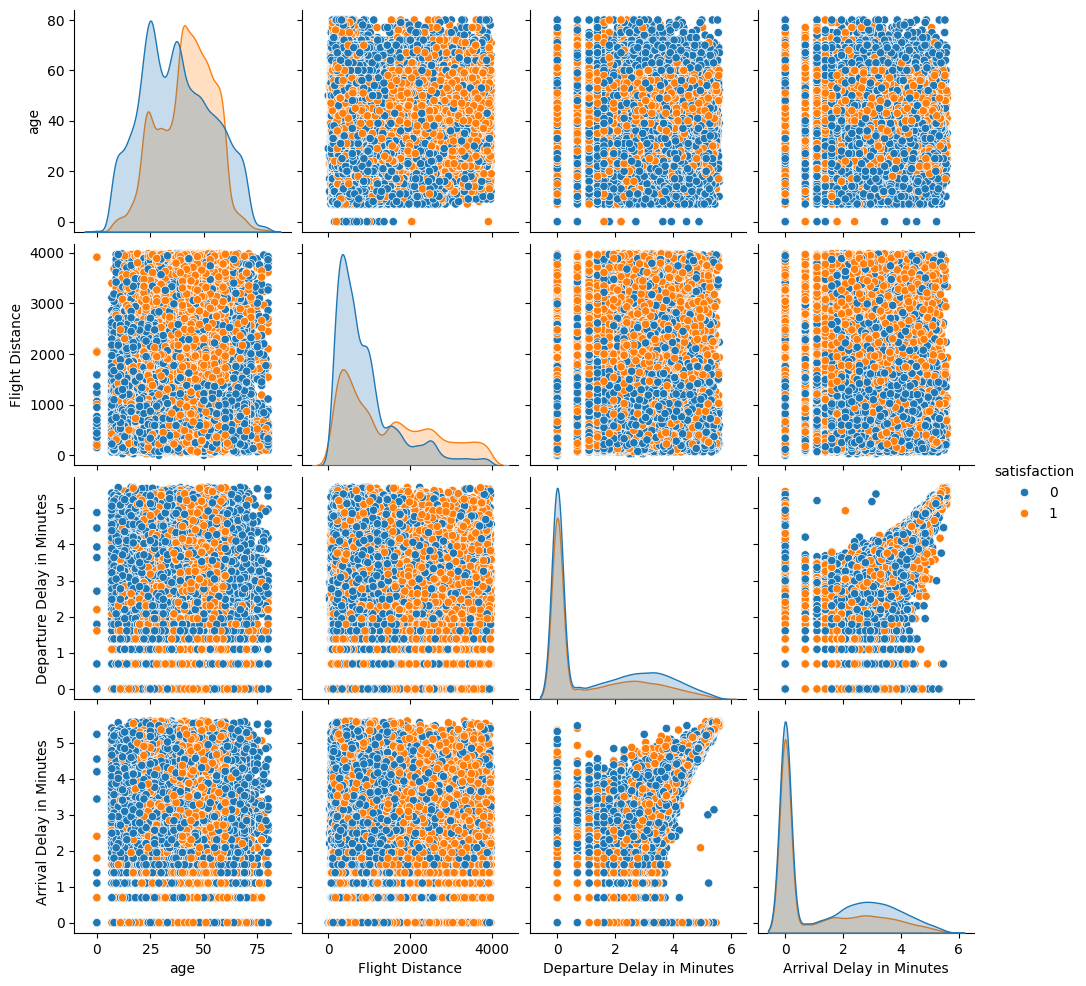

In [133]:
# your code
X_train['satisfaction'] = y_train

sns.pairplot(X_train[continuous_cols + ['satisfaction']], hue='satisfaction')
X_train.drop(columns=['satisfaction'], inplace=True)

plt.show()

# Decision Tree (3 балла)

(0.5 балла) <font color='#9933CC'>Закодируйте категориальные признаки методом OHE</font>. Для дерева используйте гиперпараметры по умолчанию.

In [184]:
# your code below
X_train_tree_encoded = pd.get_dummies(X_train_tree, drop_first=True)
X_val_tree_encoded = pd.get_dummies(X_val_tree, drop_first=True)
df_test_tree_encoded = pd.get_dummies(df_test_tree, drop_first=True)

<font color='#9933CC'>Обучите дерево решений с параметрами по умолчанию на имеющихся данных.</font> Здесь и далее везде, где вас просят что-нибудь обучить, выводите `accuracy_score` для валидационной подвыборки

In [188]:
# code here
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train_tree_encoded, y_train)

y_pred = tree_model.predict(X_val_tree_encoded)

print(f'Accuracy на валидационной подвыборке: {accuracy_score(y_val, y_pred)}')

Accuracy на валидационной подвыборке: 0.9419823760210974


## Деревья решений. Теоретическая вставка

(0.5 балла) <font color='#9933CC'>Посчитайте bias и variance для построенного дерева.</font> Для этого проще всего вспользоваться функцией `bias_variance_decomp()` из модуля mlxtend. Используйте '0-1_loss'

In [ ]:
# change *params into what needs to be there by task condition

error_dt, bias_dt, var_dt = bias_variance_decomp(tree_model,
                                                 X_train_tree_encoded.to_numpy(),
                                                 y_train.to_numpy(),
                                                 X_val_tree_encoded.to_numpy(),
                                                 y_val.to_numpy(),
                                                 loss='0-1_loss',
                                                 random_seed=42)
error_dt, bias_dt, var_dt

## Возвращение к задаче

(0.5 балла) <font color='#9933CC'>Выведите на экран barplot, демонстрирующий оценки важности признаков</font>

<Axes: ylabel='None'>

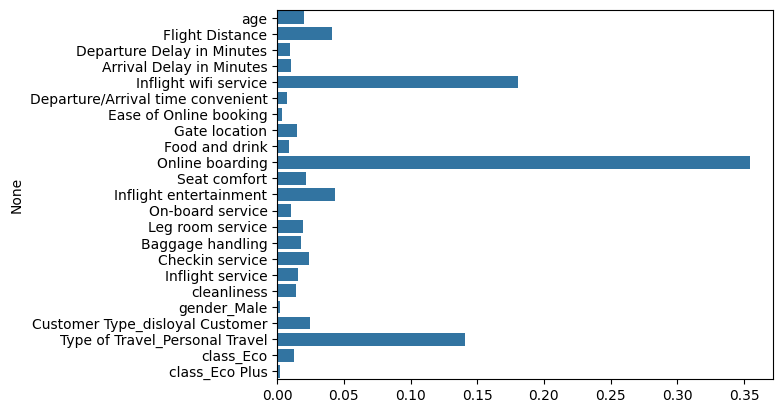

In [191]:
# the place for your code
sns.barplot(x=tree_model.feature_importances_, y=X_train_tree_encoded.columns)

<font color='#FF6600'>Какие признаки оказались наиболее информативными?</font>

In [ ]:
# your answer below
# feel free to change this cell into markdown
###  ТОП-3 самых информативных признаокв
# Online boarding
# Inflight wifi service
# Type of Travel_Personal Travel

<font color='#9933CC'>Какой глубины получилось дерево? Сколько в нем листьев?</font>

In [192]:
# глубина дерева
tree_model.get_depth()

30

In [193]:
# кол-во листьев
tree_model.get_n_leaves()

2164

<font color='#9933CC'>Постройте дерево глубины 5, используя только 2 наиболее информативных признака для предыдущего построенного дерева</font>. <font color='#FF6600'>Насколько упало качество на тесте?</font>

In [194]:
# the place for your solution
tree_model_with2 = DecisionTreeClassifier(random_state=42, max_depth=5)

two_best_features = ['Online boarding', 'Inflight wifi service']

tree_model_with2.fit(X_train_tree_encoded[two_best_features], y_train)

y_pred = tree_model_with2.predict(X_val_tree_encoded[two_best_features])

accuracy_score(y_val, y_pred)


0.8240174953367209

Качество упала менее, чем на 12 сотых, думаю интереснее было бы посмотреть на 3 лучших признаках.

(0.25 балла) <font color='#9933CC'>С помощью graphviz постройте получившееся дерево решений</font>. <font color='#FF6600'>Почему предикаты в нем не целые, а кратны 1/2?</font>

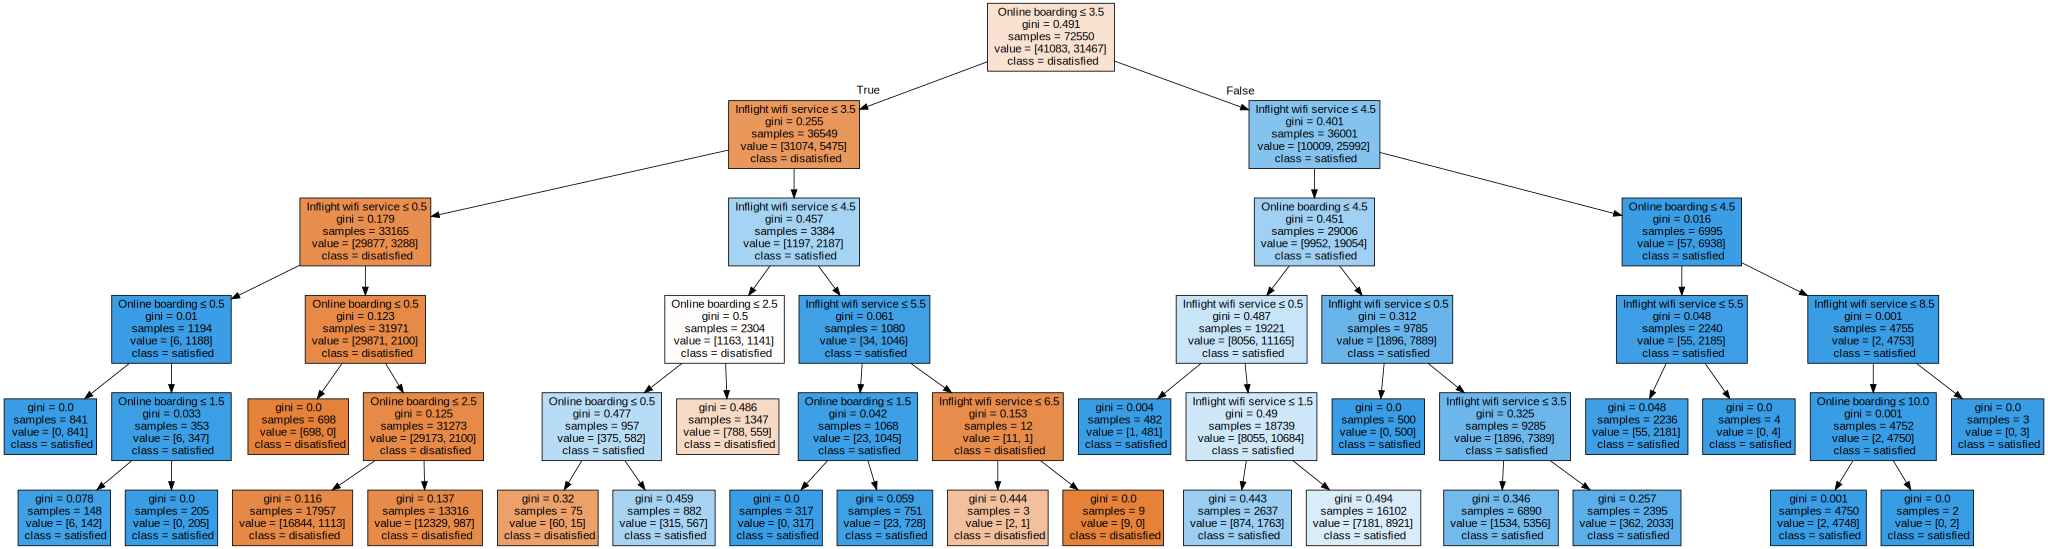

In [195]:
# feel free to google
dot_data = export_graphviz(tree_model_with2,
                          feature_names=tree_model_with2.feature_names_in_,
                          class_names=["disatisfied", "satisfied"],
                          filled=True,
                          rounded=False,
                          special_characters=True,
                          out_file=None)
graph = Source(dot_data)
graph

<font color='#9933CC'>Теперь постройте дерево той же глубины 5 для 2-х наиболее информативных континуальных (по договорённости) признаков</font>

In [196]:
# your code below
tree_model_3 = DecisionTreeClassifier(random_state=42, max_depth=5)

age_dist = ['Flight Distance', 'age']

tree_model_3.fit(X_train_tree_encoded[age_dist], y_train)

y_pred = tree_model_3.predict(X_val_tree_encoded[age_dist])

print(f'Accuracy на валидационной подвыборке: {accuracy_score(y_val, y_pred)}')


Accuracy на валидационной подвыборке: 0.6829291824789349


(0.25 балла) <font color='#9933CC'>Отобразите его функцией `plot_tree()` из sklearn</font>. <font color='#FF6600'>Симметричным ли получилось дерево? Это хорошо или плохо?</font>

Получилось симметричным. Крайне симметричное дерево, особенно с большой глубиной, может быть признаком переобучения

[Text(0.5, 0.9166666666666666, 'x[0] <= 1499.5\ngini = 0.491\nsamples = 72550\nvalue = [41083, 31467]'),
 Text(0.25, 0.75, 'x[1] <= 37.5\ngini = 0.446\nsamples = 50485\nvalue = [33506, 16979]'),
 Text(0.125, 0.5833333333333334, 'x[1] <= 19.5\ngini = 0.393\nsamples = 24408\nvalue = [17843, 6565]'),
 Text(0.0625, 0.4166666666666667, 'x[1] <= 16.5\ngini = 0.264\nsamples = 5636\nvalue = [4755, 881]'),
 Text(0.03125, 0.25, 'x[0] <= 489.5\ngini = 0.236\nsamples = 4038\nvalue = [3485, 553]'),
 Text(0.015625, 0.08333333333333333, 'gini = 0.194\nsamples = 1516\nvalue = [1351, 165]'),
 Text(0.046875, 0.08333333333333333, 'gini = 0.26\nsamples = 2522\nvalue = [2134, 388]'),
 Text(0.09375, 0.25, 'x[0] <= 505.0\ngini = 0.326\nsamples = 1598\nvalue = [1270, 328]'),
 Text(0.078125, 0.08333333333333333, 'gini = 0.248\nsamples = 691\nvalue = [591, 100]'),
 Text(0.109375, 0.08333333333333333, 'gini = 0.376\nsamples = 907\nvalue = [679, 228]'),
 Text(0.1875, 0.4166666666666667, 'x[0] <= 1354.0\ngini = 0.

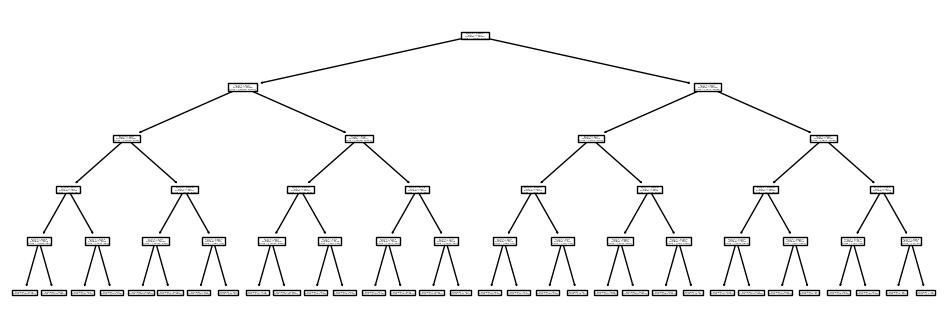

In [197]:
# another place to code a few lines
plt.figure(figsize=(12, 4))
plot_tree(tree_model_3)

(0.5 балла) <font color='#9933CC'>Используя функцию `plot_decision_regions()` из `mlxtend`, отобразите разделяющую поверхность получившегося дерева.</font> Отметьте на графике только первые 100 объектов обучающей выборки

In [199]:
# your line of code
plot_decision_regions(X=X_train_tree_encoded[age_dist].head(100).values,
                      y=y_train.head(100).values,
                      clf=tree_model_3,
                      legend=2)

# Настройки графика
plt.xlabel('Distance')
plt.ylabel('Age')
plt.title('Decision Boundary of the Decision Tree')
plt.show()


ValueError: invalid literal for int() with base 10: 'neutral or dissatisfied'

## Деревья решений. Теоретическая вставка 2

Из лекций вам должно быть известно, что деревья решений неустойчивы даже к небольшим изменениям в обучающей выборке. Попробуем показать это

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


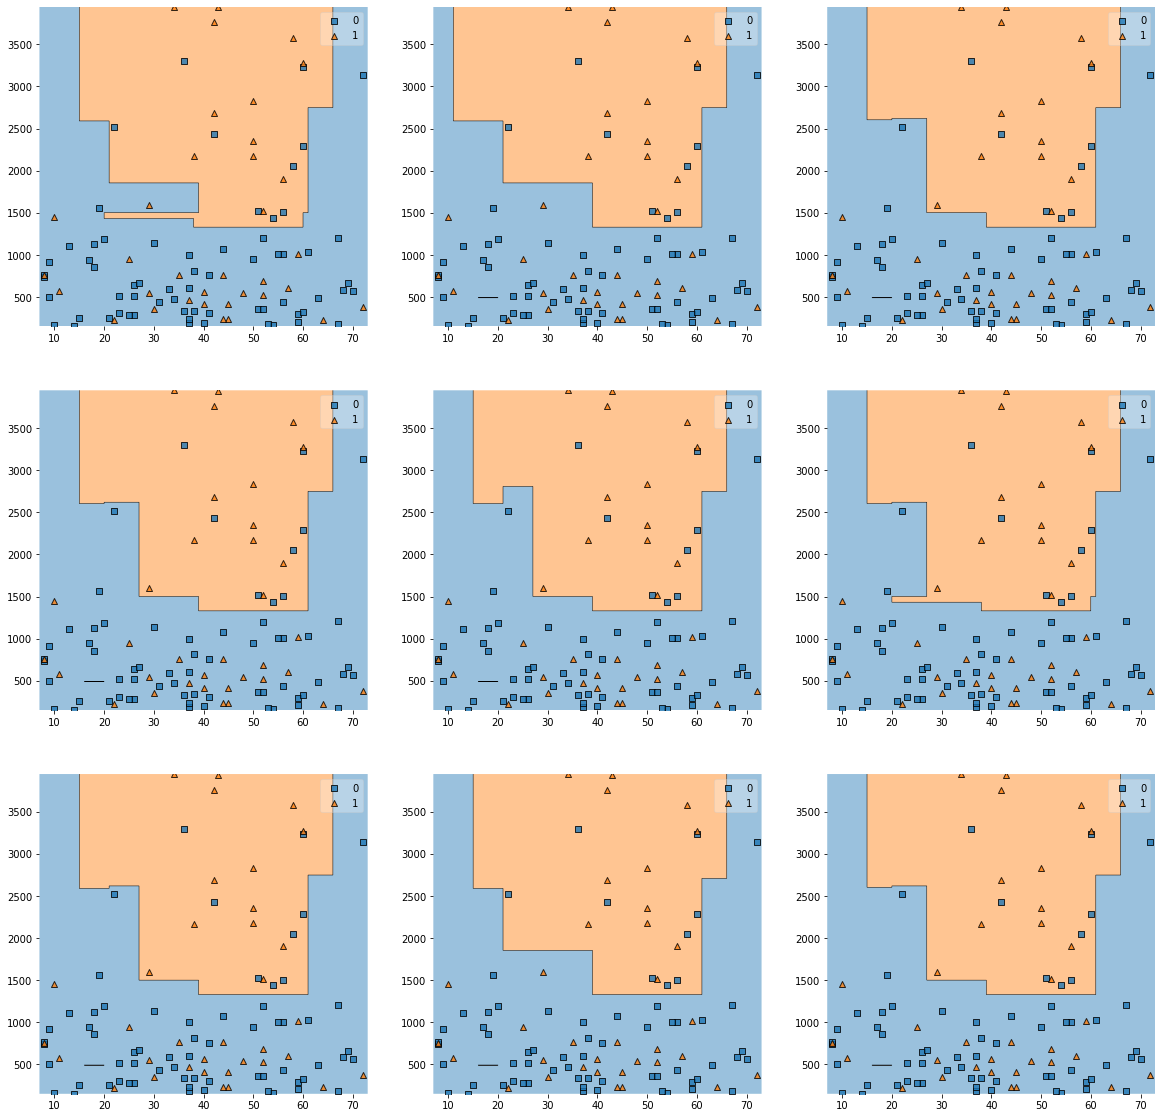

In [ ]:
# change X_train_example to your equivalent

fig, ax = plt.subplots(3, 3, figsize=(20, 20))

for row in range(3):
    for col in range(3):
        inds = np.random.choice(X_train_example.index, size=X_train_example.shape[0] - 1000, replace=False) # нагляднее брать не на 1к, а на 5к меньше объектов, а то почти не изменяется разделяющая поверхность

        tree_exp = DecisionTreeClassifier(max_depth=5, random_state=42)
        tree_exp.fit(X_train_example.loc[inds, :], y_train[inds])

        plot_decision_regions(clf=tree_exp, X=np.array(X_train_example.iloc[:100, :]), y=np.array(y_train[:100]), ax=ax[row][col])

Мы убирали из трейна (а в нем ~80к наблюдений) всего по тысяче случайных объектов!

Помимо своей неусточивости деревья решений "славны" ещё и склонностью к переобучению. Посмотрим, можно ли увидеть это свойство на имеющихся у нас данных. Для этого будем обучать алгоритм DT на всем трейне с разной глубиной дерева и считать accuracy для теста

In [ ]:
# change X_train_enc into your ohe-encoded train set

%%time
depths = [2, 3, 5, 10, 15, 20, 25, 32, 50, 64, 75, 100]

accuracies_train = []
accuracies_test = []
for max_depth in depths:
    DT = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    DT.fit(X_train_enc, y_train)
    y_predicted_train = DT.predict(X_train_enc)
    y_predicted_val = DT.predict(X_val_enc)
    accuracies_train.append(accuracy_score(y_train, y_predicted_train))
    accuracies_test.append(accuracy_score(y_val, y_predicted_val))

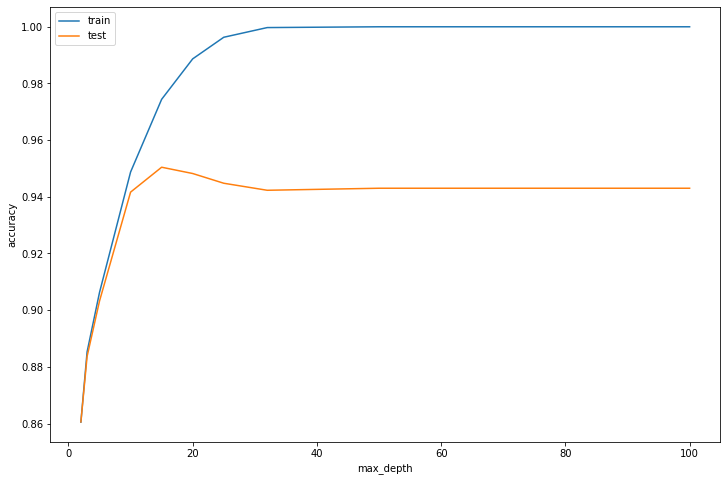

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(depths, accuracies_train, depths, accuracies_test)
plt.legend(['train', 'test'])
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.show()

Нам повезло выйти на ассимптоту на тесте. Однако так бывает далеко не всегда. Так что подбирать гипрепараметры для деревьев решений стоит осторожно

## Возвращение к задаче

(0.5 балла) <font color='#9933CC'>На кроссвалидации подберите оптимальные гиперпараметры для дерева решений</font> *(по данным со всеми признаками -- не на модельном примере из теоретической вставки)*. <font color='#FF6600'>Удалось ли улучшить качество предсказаний подбором гиперпараметров?</font>

In [ ]:
# you know what to do



<font color='#9933CC'> Сохраните лучшее дерево в pickle </font>

*Мы просим это сделать, чтобы вы в случае чего не тратили время на переобучение, а могли банально подгрузить из файла*

In [ ]:
with open('DT.pkl', 'wb') as f:
    pass

# Random Forest (4 балла)

<font color='#9933CC'>Обучите случайный лес с параметрами по умолчанию</font>

In [ ]:
# -__-



(0.75 балла) <font color='#9933CC'>Выведите калибровочную кривую для полученного ансамбля</font>

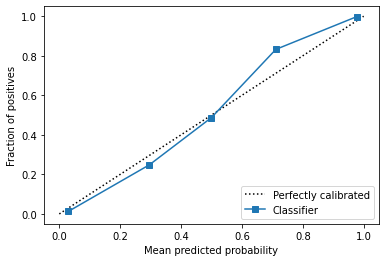

In [ ]:
# some lines of your code



Похоже, мы немного недооцениваем высокие вероятности

<img src='https://habrastorage.org/r/w1560/getpro/habr/upload_files/510/4e0/63b/5104e063b62bd0ac6b87da44a3034aa5.png'>

Изображение взято из статьи ["predict_proba в Python не прогнозирует вероятности (и как с этим бороться)"](https://habr.com/ru/company/otus/blog/573924/) с Хабра

<font color='#FF6600'>Вспомните (или выведите), корректно ли деревья предсказывают вероятности?</font>

In [ ]:
# your answer below
# feel free to change this cell into markdown



<font color='#9933CC'>Обучите логистическую регрессию с параметрами по умолчанию и отобразите её калибровочную кривую</font>

UPD: не с параметрами по умолчанию, а так, чтоб сошлась

CPU times: user 530 ms, sys: 278 ms, total: 808 ms
Wall time: 431 ms


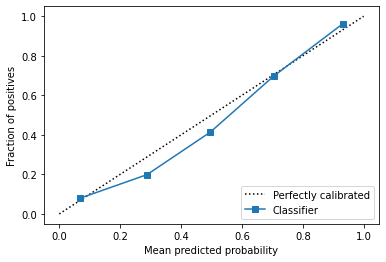

In [ ]:
# --____--



Мы немного переоцениваем предсказанные низкие вероятности

<font color='#FF6600'>Покажите, почему считается, что логистическая регрессия корректно предсказывает вероятности?</font>

In [ ]:
# maths needed



(0.75 балла) <font color='#9933CC'>Предлагаем вам попробовать откалибровать вероятности обученного случайного леса</font>. Для этого воспользуйтесь логистической и изотонической регрессиями. <font color='#FF6600'>Интерпретируйте полученные результаты</font>

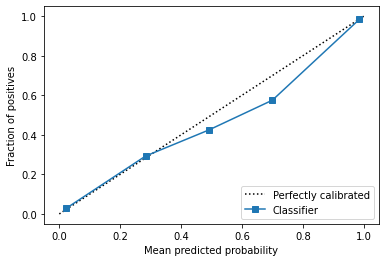

In [ ]:
# yet another code cell for logreg



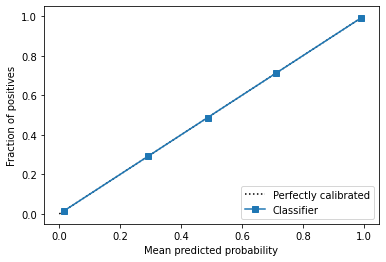

In [ ]:
# yet another code cell for isoreg



<font color='#FF6600'>Опишите другие возвожные подходы к калбировке вероятностей (со ссылками на источники)</font>

In [ ]:
# feel free to change this cell into markdown



(1 балл) <font color='#9933CC'>Посчитайте разброс и смещение полученного случайного леса (до калибровки).</font><font color='#FF6600'>Оличаются ли они от полученных для дерева решений? Соответствуют ли полученные на реальных данных отличия (//совпадения) от тех, что должны быть в теории? По каким причинам?</font>

In [ ]:
# one more place for your code



<font color='#9933CC'>Вычислите разложение ошибки для логистической регрессии (ванильной, не той, что использовали для калибровки).</font> <font color='#FF6600'>Сравните полученные результаты с предыдущими. Объясните природу этих результатов</font>

In [ ]:
# (•_•)


(1 балл) <font color='#9933CC'>Попробуйте подобрать оптимальные гиперпараметры, используя `RandomizedSearchCV`</font>. Хотя бы один из гиперпараметров перебирайте из распределения (например, `uniform` из `scipy.stats`)

In [ ]:
# your code here



## Случайный лес. Вставка теории

На модельном примере посмотрим, склонен ли случайный лес к переобучению с ростом числа деревьев в композиции.

Возьмем 4 полезных признака из одного из предыдщущих заданий, напоминающих теорию

In [ ]:
# change X_train_enc into you equivalent

cols_for_RF = ['age', 'Flight Distance', 'Online boarding', 'Inflight wifi service']
X_train_RF = X_train_enc[cols_for_RF]
# а тест нам не понадобится, ведь можно получить OOB-estimate ошибки

clf = RandomForestClassifier(warm_start=True, oob_score=True, random_state=42)
errors = []

for n_estimators in range(1, 251, 5):
    clf.set_params(n_estimators=n_estimators)
    clf.fit(X_train_RF, y_train)

    errors.append(1 - clf.oob_score_)

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.


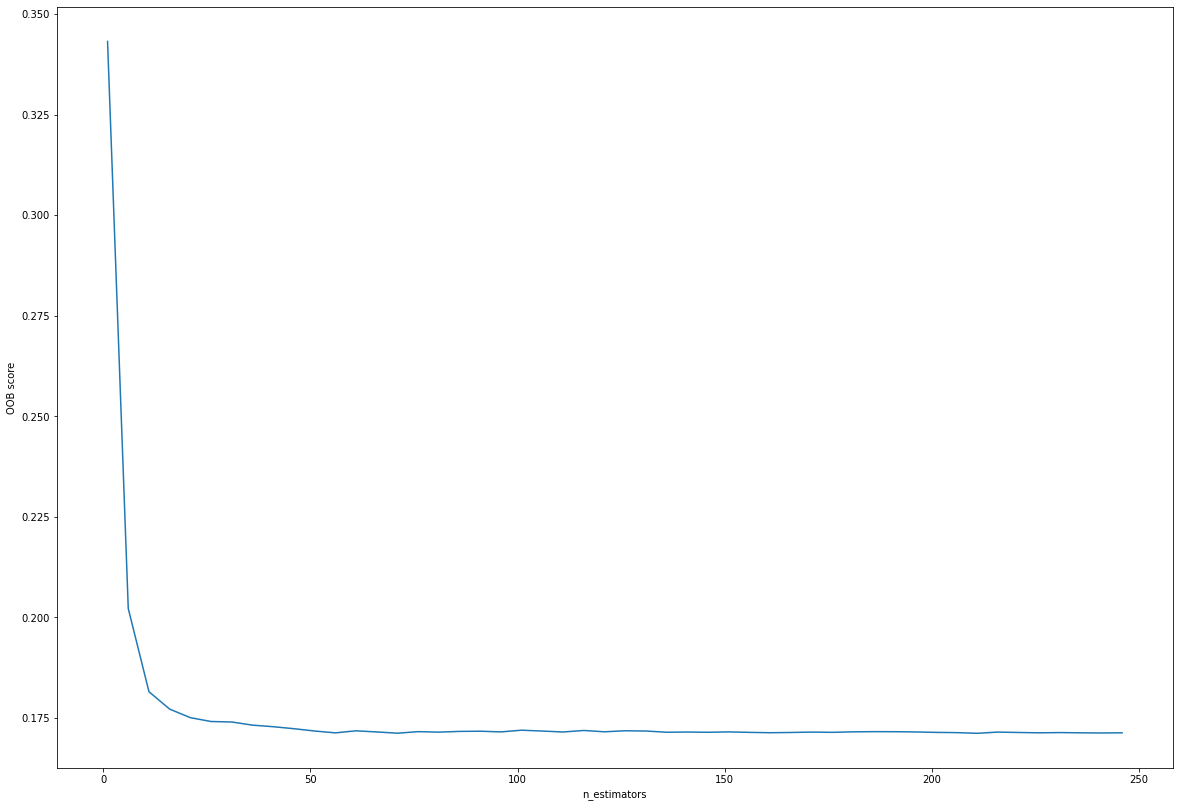

In [ ]:
plt.figure(figsize=(20, 14))
plt.plot(range(1, 251, 5), errors)

plt.xlabel('n_estimators')
plt.ylabel('OOB score')
plt.show()

> **Дисклеймер**: отсутствие переобучения с ростом числа деревьев вовсе не означает, что сама модель случайного леса не может быть переобучена. Базовые деревья такой композиции могут переобучаться. Значит, и вся композиция вполне способна оказаться переобученной

## Возвращение к задаче

<font color='#9933CC'>Отобразите `feature_importances_` вашего лучшего случайного леса</font>

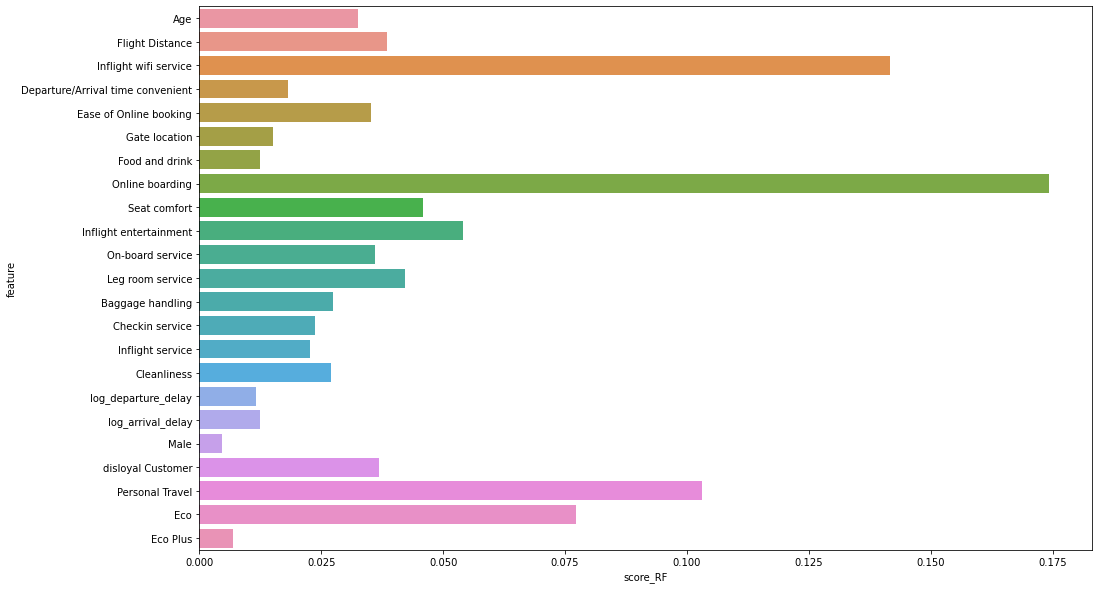

In [ ]:
# (•_•)

(0.5 балла) <font color='#9933CC'>Сравните важности признаков для дерева решений и для случайного леса. Постройте диаграмму</font>

In [ ]:
# -__-

Бонус (0.5 балла) <font color='#9933CC'>Интерпретируйте важности признаков с помощью SHAP</font>. Для подсчета используйте 1000 случайных объектов, иначе не дождетесь за приемлемое время

[Статья "Интерпретация моделей и диагностика сдвига данных: LIME, SHAP и Shapley Flow"](https://habr.com/ru/company/ods/blog/599573/) из блога ods.ai на Хабре

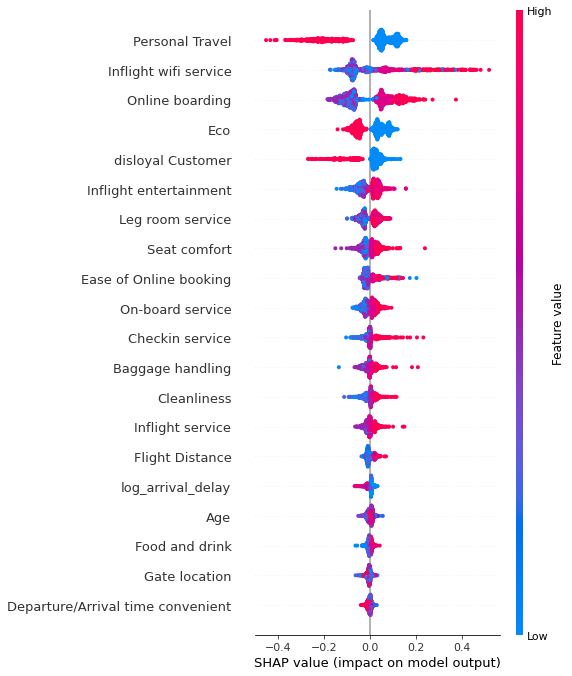

CPU times: user 5min 45s, sys: 2.77 s, total: 5min 47s
Wall time: 5min 45s


In [ ]:
# (•_•)


<font color='#FF6600'>Опишите полученый график</font>

In [ ]:
# your explanation below


<font color='#FF6600'>Изучите документацию библиотеки SHAP. Что ещё полезного в ней имеется? </font>

In [ ]:
# feel free to change this cell into markdown



Бонус (0.5 балла) <font color='#9933CC'>Интерпретируйте важности признаков с помощью LIME</font>

In [ ]:
# please type your solution below



X does not have valid feature names, but RandomForestClassifier was fitted with feature names


CPU times: user 13 s, sys: 918 ms, total: 13.9 s
Wall time: 16.1 s


<font color='#FF6600'>Опишите полученый график</font>

In [ ]:
# your explanation below


<font color='#9933CC'>Случайное лес, дающий лучший скор, сохраните в pickle</font>

# Новый раздел

# Обратная связь

Расскажите, как вам это домашнее задание. Было ли оно полезным? Научились ли вы чему то? Насколько сложным по 10-балльной шкале оно вам показалось? Сколько времени у вас ушло на его выполнение? Что следовало ещё в него включить? Было ли что-то лишнее?

Я перевелся с другой программы и делала дз в условиях большого ограничения по времени. Мне пока все дается тяжело. По 10-балльной шкале для меня на 8. На выполнение ушло около 16 часов. Обычно я засекаю время работы, поэтому могу сказать достаточно точно. Часть времени проработал ночью, а ночью я хуже работаю, поэтому, наверное, смог бы сделать немного быстрее.